# CarND-Term1-P4
## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Processing Steps

## Pre-steps
0 First -> Calibrate the camera, this to get the camera matrix (cMat) and distortion coefficients (coefs)

## Main Pipeline steps:
1. Undistort the image (distortion correction)
2. Use color & gradient threshold
3. Perspective transform (to view the image from top-down)
4. Identify the lane lines in the warped image
5. Back to the original perspective and draw lane and lines


#### Step 0 -> Camera calibration
Before any step, it's necessary get the camera distortion coeficients.
We'll inpect pictures of a chessboard pattern using cv2 special functions.
With this coefficients we'll be able to undistort the images.

In [5]:
#######################################################################################################################
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#######################################################################################################################
# CAMERA CALIBRATION (pre-step)
#######################################################################################################################

ret, cMat, coefs, rvects, tvects = None, None, None, None, None

def camera_calibration():
    i = 0
    im_paths = glob.glob('./camera_cal/calibration*.jpg')

    cb_shape = (9, 6)  # Corners we expect to be detected on the chessboard

    obj_points = []  # 3D points in real-world space (undistorted)
    img_points = []  # 2D points in the image
    for im_path in im_paths:
        img = mpimg.imread(im_path)

        obj_p = np.zeros((cb_shape[0]*cb_shape[1], 3), np.float32)
        coords = np.mgrid[0:cb_shape[0], 0:cb_shape[1]].T.reshape(-1, 2)  # x, y coords

        obj_p[:,:2] = coords

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found_all, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        if found_all:
            img_points.append(corners)
            obj_points.append(obj_p)
            #img = cv2.drawChessboardCorners(img, cb_shape, corners, found_all)            
        else:
            print("can't find all the corners in image:", im_path)
    return cv2.calibrateCamera(obj_points, img_points, gray.shape, None, None)
#return: ret, mtx(camera matrix to transform 3d object to 2d image points), dist(dist coefs), 
    #rvecs(camera rotation vector), tvecs(camera translation vector)
ret, cMat, coefs, rvects, tvects = camera_calibration()
print("Camera distortion coefs:", coefs)


Camera distortion coefs: [[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]


#### Plot functions

In [6]:
#######################################################################################################################
# Plot helper functions
#######################################################################################################################
# draw one big image (could fail because an unknown bug)
def one_plot(img):
    # Plots one big image    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

# draw two medium images
def two_plots(img1, img2, img1_title=None, img2_title=None):
    # Plots two images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(img1)
    if img1_title: ax1.set_title(img1_title, fontsize=30)
    ax2.imshow(img2)
    if img2_title: ax2.set_title(img2_title, fontsize=30)


#### Step 1 -> Undistort images
Left show the original image and right the undistorted image.
The effect it's much easier to see in the chessboard image, but there are some signs of the effect in the image below (road), for example the white car on the bottom right.

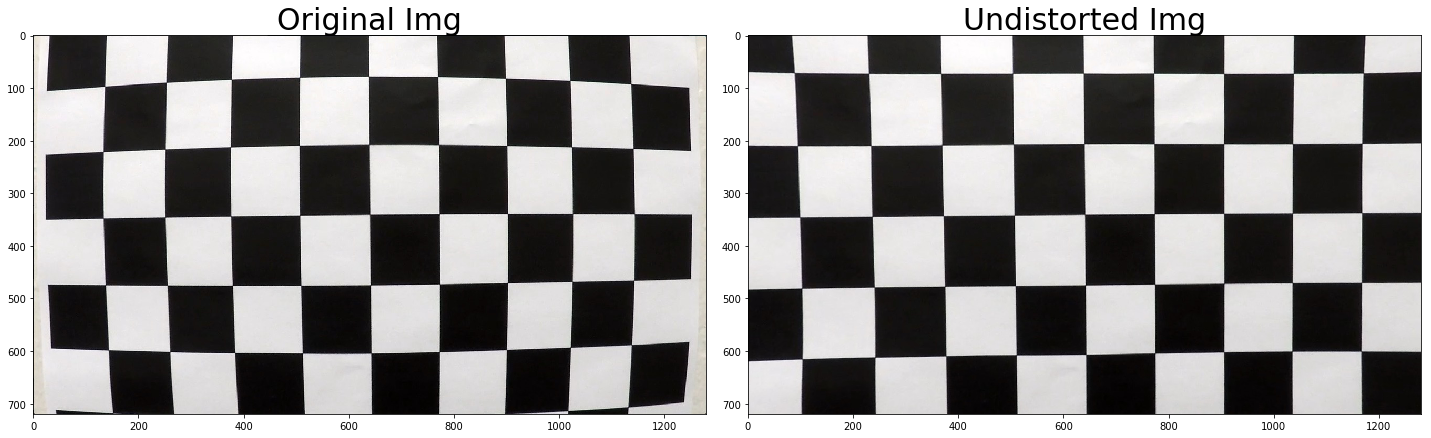

In [7]:
#######################################################################################################################
# Step1: undistort images
#######################################################################################################################
def undistort_img(img):
    if cMat is None: raise Exception('Error, camera is not calibrated -> exit')
    
    return cv2.undistort(img, cMat, coefs, None, cMat)

original_image = mpimg.imread('./camera_cal/bad_imgs/calibration1.jpg')
img_undistorted = undistort_img(original_image)
# save image
cv2.imwrite('./output_images/undistorted_checkerboard.jpg', img_undistorted)
# nice plot 
two_plots(original_image, img_undistorted, 'Original Img', 'Undistorted Img')

Testing undistort image


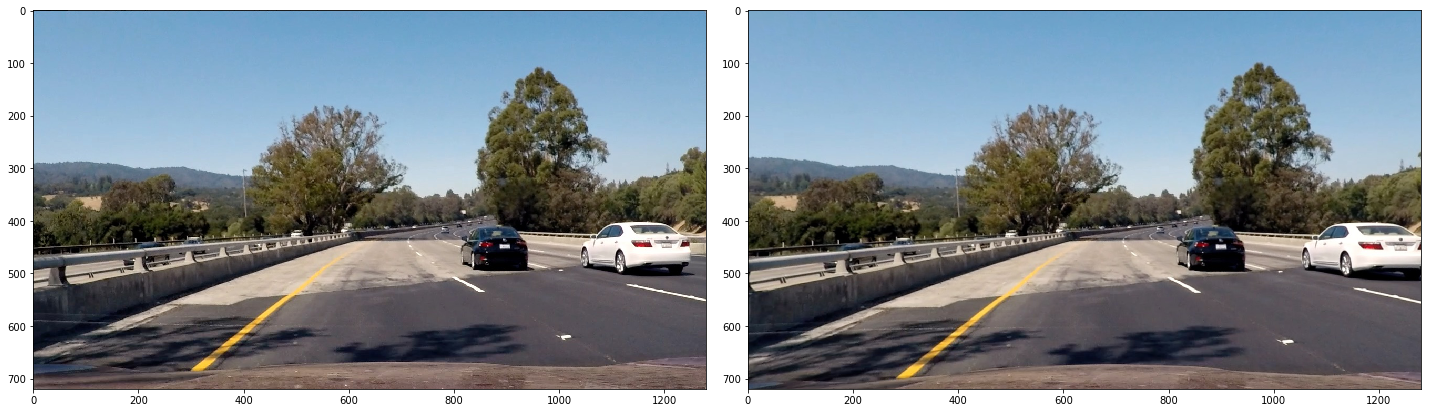

In [8]:
# testing undistort_img()
original_img = mpimg.imread('./test_images/test4.jpg')
undistorted_img = undistort_img(original_img)
two_plots(original_img, undistorted_img)
print('Testing undistort image')

#### Step 2 -> Use color && gradient threshold
It's needed a thresholding method that will utilize gradients and colors for lane lines detection in the images.
Thresholding works better using a combination of the S-CHANNEL from HLS color space and Sobel Gradient.

In [14]:
#######################################################################################################################
# Step2: Use color & gradient threshold
#######################################################################################################################
def sobel_bin_img(img):   
    # require -> img should be 1-channel
    # x-direction gradient
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)  
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_bin = np.zeros_like(scaled_sobel)
    sobel_bin[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1    
    return sobel_bin

def threshold_img(img, show=False):
    # require -> im should be an undistorted image    
    # color-space conversion
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]    
    # sobel gradient bins
    sobel_s_bin = sobel_bin_img(s_channel)
    sobel_gray_bin = sobel_bin_img(gray)
    sobel_comb_bin = np.zeros_like(sobel_s_bin)
    sobel_comb_bin[(sobel_s_bin == 1) | (sobel_gray_bin == 1)] = 1
    # HLS S-Channel binary
    s_bin = np.zeros_like(s_channel)
    s_bin[(s_channel >= 150) & (s_channel <= 255)] = 1        
    comb_bin = np.zeros_like(sobel_comb_bin)
    comb_bin[(sobel_comb_bin == 1) | (s_bin == 1)] = 1    
    gray_img = np.dstack((gray, gray, gray))
    sobel_s_img = np.dstack((sobel_s_bin, sobel_s_bin, sobel_s_bin))*255
    sobel_gray_img = np.dstack((sobel_gray_bin, sobel_gray_bin, sobel_gray_bin))*255
    sobel_comb_img = np.dstack((sobel_comb_bin, sobel_comb_bin, sobel_comb_bin))*255
    s_img = np.dstack((s_bin, s_bin, s_bin))*255
    comb_img = np.dstack((comb_bin, comb_bin, comb_bin))*255
    
    if show: two_plots(img, comb_img, 'Original', 'Thresholded')
    
    return comb_img


Testing threshold


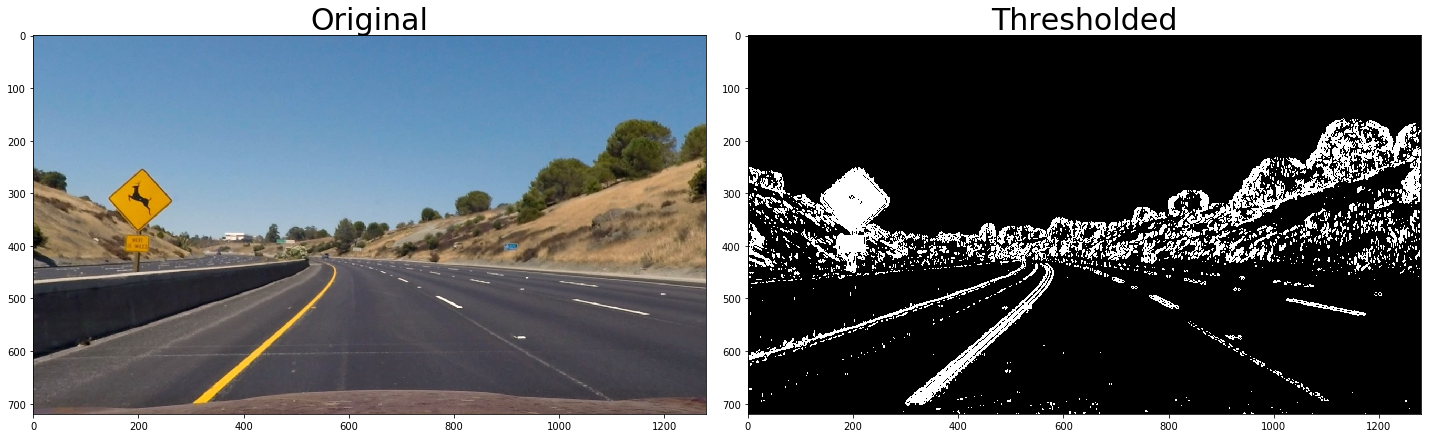

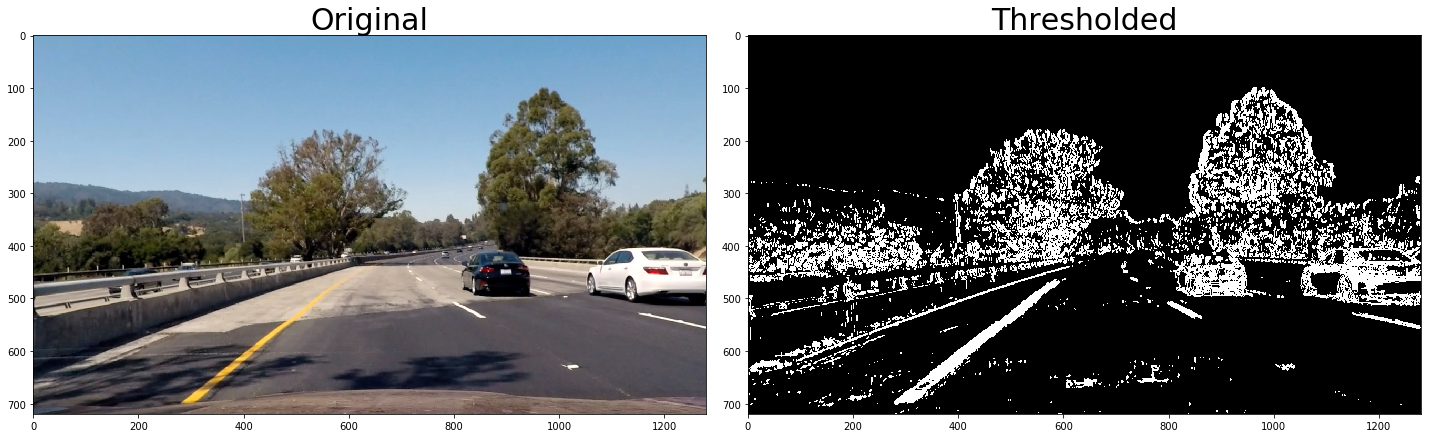

In [15]:
# testing threshold (in 2 images)
original_img1 = mpimg.imread('./test_images/test2.jpg')
undistorted_img1 = undistort_img(original_img1)
threshold_img1 = threshold_img(undistorted_img1, show=True)
# save image
cv2.imwrite('./output_images/threshold_test2.jpg', threshold_img1)

original_img1 = mpimg.imread('./test_images/test4.jpg')
undistorted_img1 = undistort_img(original_img1)
threshold_img1 = threshold_img(undistorted_img1, show=True)
# save image
cv2.imwrite('./output_images/threshold_test4.jpg', threshold_img1)
print('Testing threshold')

#### Step 3 -> Perspective transform
With undistorted and thresholded images we get importante information, but also it's necessary limit that information by looking only at the portion of the image that is the only that matters (the road)
To get that, we'll apply a perspective transform to shift our perspective to a top-down view of the road in front of the car.

True

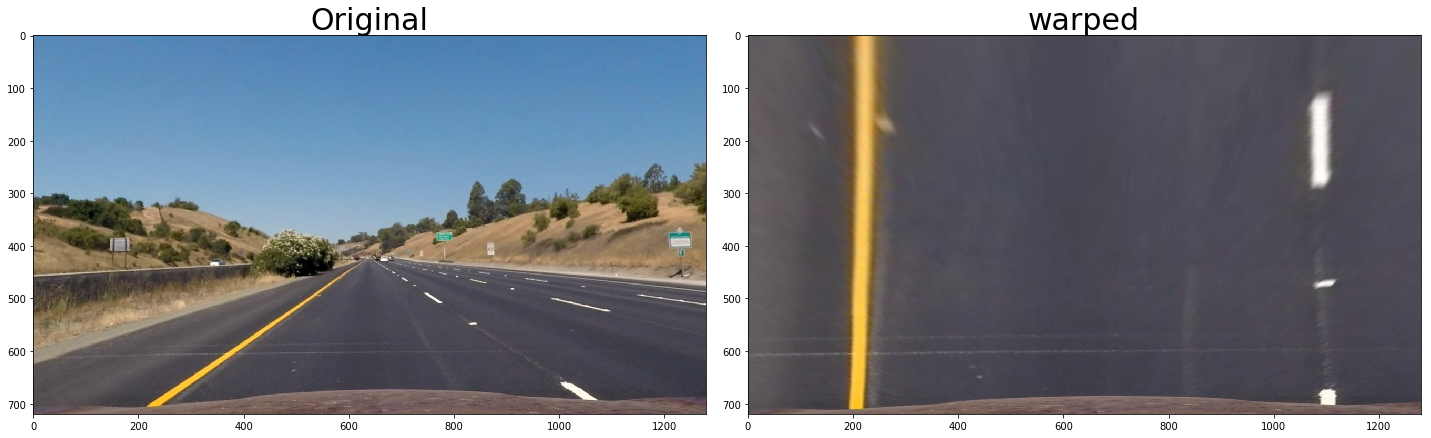

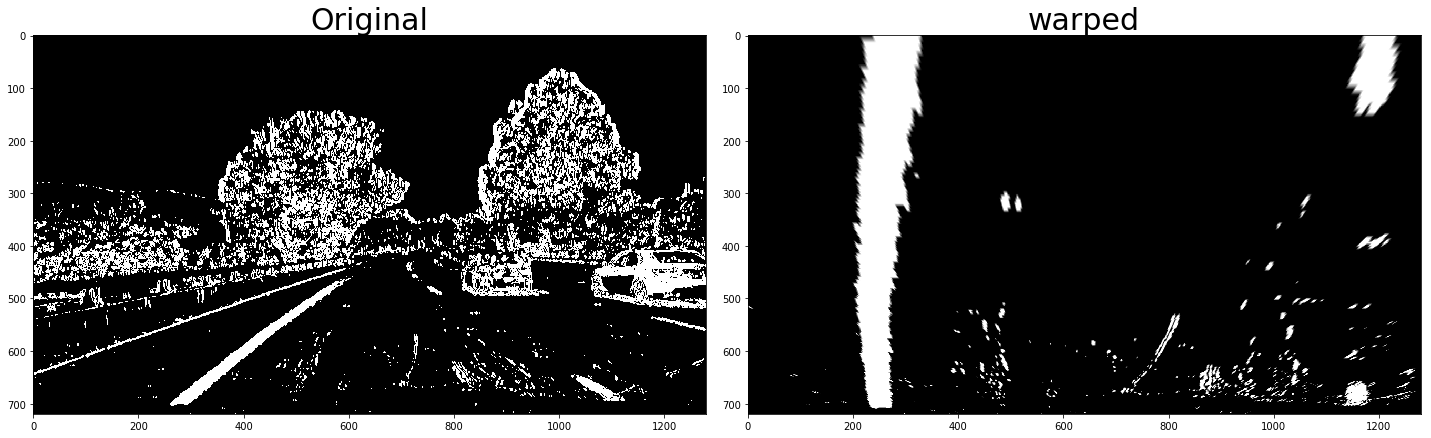

In [16]:
#######################################################################################################################
# Step3: Perspective transform
#######################################################################################################################
def warp_to_lines(img, show=False):
    # require ->img should be an undistorted image
    x_shape, y_shape = img.shape[1], img.shape[0]
    middle_x = x_shape//2
    top_y = 2*y_shape//3
    top_margin = 93
    bottom_margin = 450
    points = [
        (middle_x-top_margin, top_y),
        (middle_x+top_margin, top_y),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ]

    src = np.float32(points)
    dst = np.float32([
        (middle_x-bottom_margin, 0),
        (middle_x+bottom_margin, 0),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (x_shape, y_shape), flags=cv2.INTER_LINEAR)    
    if show: two_plots(img, warped, 'Original', 'warped')        
    return warped, M, Minv

img = mpimg.imread('./test_images/straight_lines1.jpg')
img = undistort_img(img)
warped, M, Minv = warp_to_lines(img, show=True)

original_img = mpimg.imread('./test_images/test1.jpg')
undistorted_img = undistort_img(original_img)
thresholded_img = threshold_img(undistorted_img)
warped, M, Minv = warp_to_lines(thresholded_img, show=True)
cv2.imwrite('./output_images/warped_threshold_test2.jpg', warped)

#### Step 4 -> Identify the lane lines in te warped image
We'll use a histogram at the bottom of the image to identify where the lanes start.
The peaks should be our lane lines.
Using a sliding-windows search we'll begin our search (using these peaks)


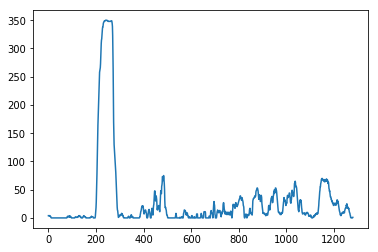

In [118]:
#######################################################################################################################
# Step4: Identify the lane lines in the warped image
#######################################################################################################################
warped_bin = np.zeros_like(warped[:,:,0])
warped_bin[(warped[:,:,0] > 0)] = 1
# Sum the columns in the bottom half of the image
histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)  
plt.plot(histogram)
plt.savefig('./output_images/histogram.png')

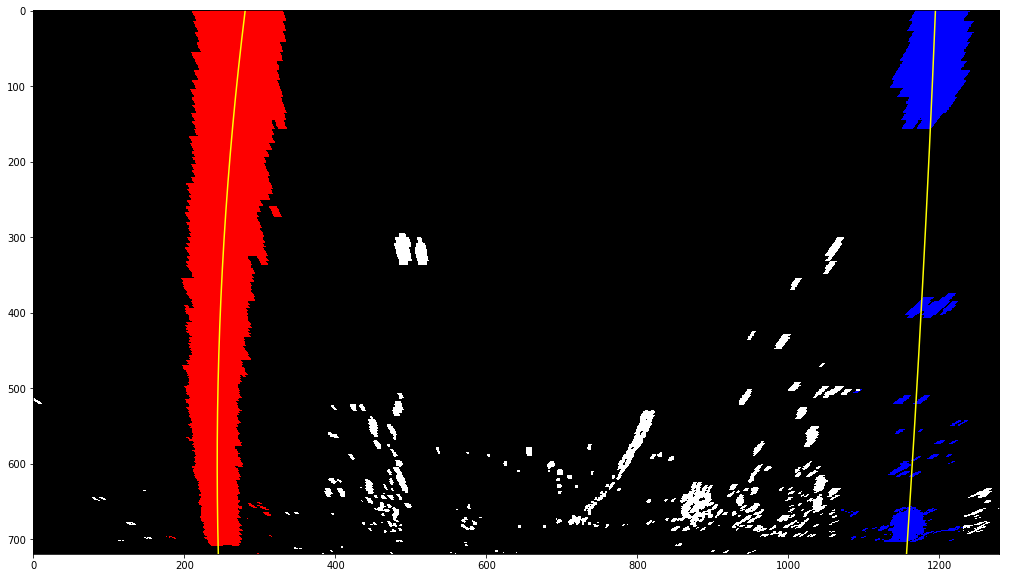

In [18]:
def find_lane(warped, show=False):
    # make binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1    
    # image we will draw on to show the lane-finding process
    vis_img = warped.copy()  
    # max out non-black pixels so we can remove them later
    vis_img[vis_img > 0] = 255  
    # sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    # x-position for the left window
    left_x = np.argmax(histogram[:midpoint])  
    # x-position for the right window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  
    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    # determines how wide the window is
    margin = 80  
    pix_to_recenter = margin*2  
    # find the non-zero x and y indices
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])
    left_line_ind, right_line_ind = [], []
    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)        
        ###
        # record the non-zero pixels within the windows
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)
        # if there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))

    # combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)
    # gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]
    # color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  
    vis_img[right_y, right_x] = [0, 0, 254]  
    # fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    # get our x/y vals for the fit lines
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]
    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        cv2.imwrite('./output_images/lane_detection_warped_test2.jpg', vis_img)
        
    lane_lines_img = vis_img.copy()
    # remove everything except the colored lane lines
    lane_lines_img[lane_lines_img == 255] = 0  
    
    return y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img

y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img = find_lane(warped, show=True)

#### Step 5 -> Back to the original perspective and draw lane and lines
Now that we've identified the lane lines, with this information now we can draw over the original image the augmented lanes, applying a reverse perpective transform and drawing over the image. For that, we've created a basic lane line detection.

Basic lane detection pipe


True

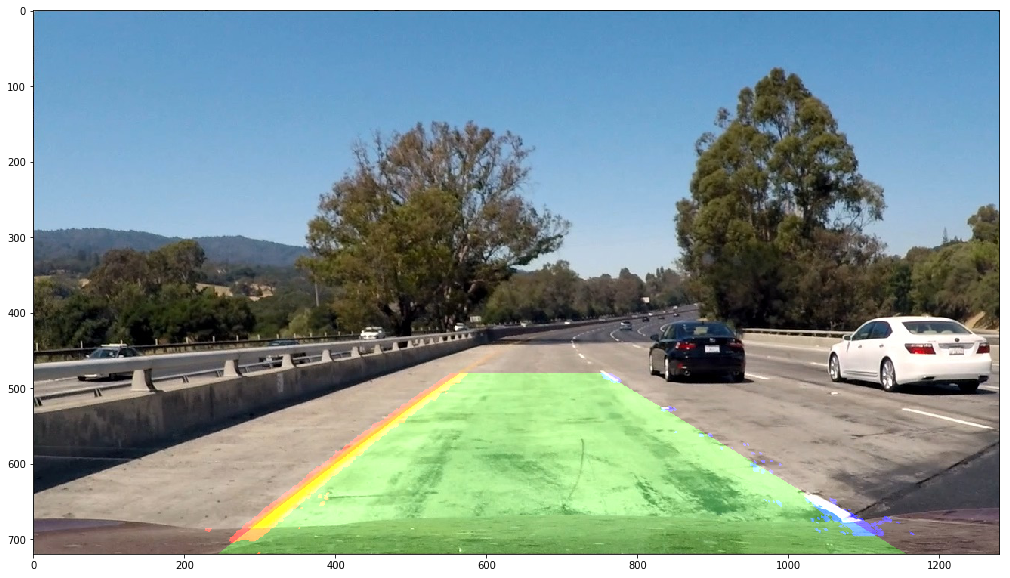

In [121]:
#######################################################################################################################
# Step5: Back to the original perspective and draw lane and lines
#######################################################################################################################
def draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=False):
    # Prepare the x/y points for cv2.fillPoly()
    left_points = np.array([np.vstack([left_x_vals, y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([right_x_vals, y_vals]).T)])
    # right_points = np.array([np.vstack([right_x_vals, y_vals]).T])
    points = np.hstack((left_points, right_points))

    # Color the area between the lines (the lane)
    lane = np.zeros_like(lane_lines_img)  # Create a blank canvas to draw the lane on
    cv2.fillPoly(lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane_lines_img, 1, lane, .3, 0)

    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    
    if show: 
        #one_plot(drawn_img)
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(drawn_img)
        
    return drawn_img

img = original_img
#drawn_img = draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=True)

def basic_lane_detection_pipe(img, show=False):    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort_img(img)
    threshed = threshold_img(undist)
    warped, M, Minv = warp_to_lines(threshed)
    y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img = find_lane(warped)
    drawn_img = draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=show)
    return drawn_img

print('Basic lane detection pipe')
drawn_img = basic_lane_detection_pipe('./test_images/test1.jpg', show=True)
drawn_img_wr = cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('./output_images/basic_lane_detection_pipeline.jpg', drawn_img_wr)


#### Putting all together into a class -> Lane class
##### Determine how far rom center of lane the car is and estimates the curvature of the lane
To make the code more useful and efficient, we created a basic Lane class.
Ass well, created the other method to meassuring the curvature of the lane and how far the car is from the center of the lane. (this information could be useful to calculate steering angles)
The information HUD will be shown on the top-center of the image.


True

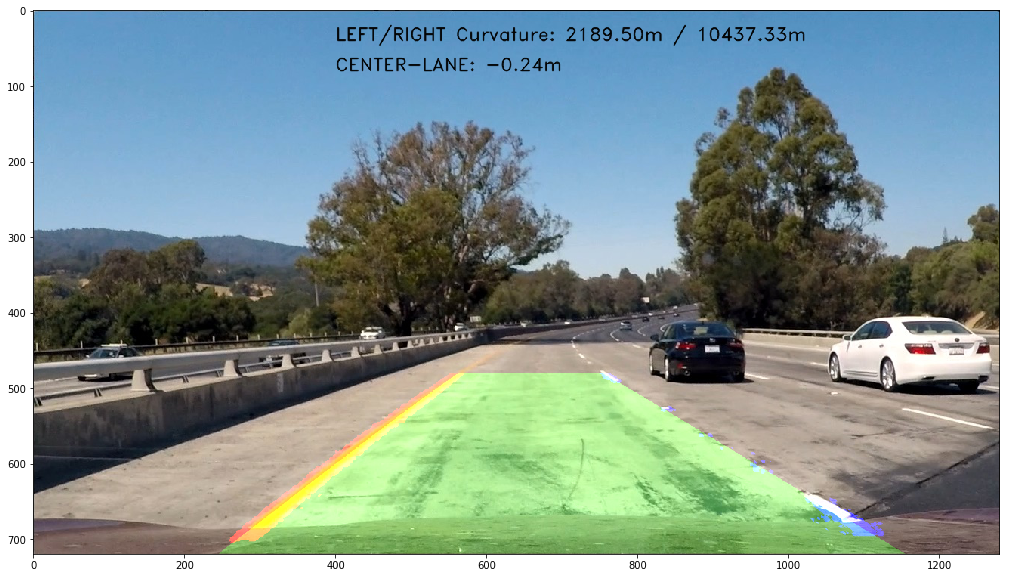

In [19]:
#######################################################################################################################
## Class Lane
#######################################################################################################################
class Lane():
    def __init__(self):
        self.y_vals = None
        self.left_x_vals = None
        self.right_x_vals = None
        self.lane_lines_img = None
        self.left_curvature = None
        self.right_curvature = None
        self.offset = None

def calc_curvature(y_to_fit, x_to_fit, y_eval):
    # conversion factors for pixels to meters
    m_per_pix_y, m_per_pix_x = 30/720, 3.7/700 
    # fit a new polynomial to world-space (in meters)
    fit = np.polyfit(y_to_fit*m_per_pix_y, x_to_fit*m_per_pix_x, 2)
    curvature = ((1 + (2*fit[0]*(y_eval*m_per_pix_y) + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return curvature

def calc_offset(left_x, right_x, img_center_x):
    lane_width = abs(left_x - right_x)
    lane_center_x = (left_x + right_x)//2
    pix_offset = img_center_x - lane_center_x
    # expected the lane to be in meters
    lane_width_m = 3.7  
    return lane_width_m * (pix_offset/lane_width)
          
def find_lane(warped, show=False):
    # Create a binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1
    vis_img = warped.copy()  # The image we will draw on to show the lane-finding process
    vis_img[vis_img > 0] = 255  # Max out non-black pixels so we can remove them later
    # Sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # Find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    left_x = np.argmax(histogram[:midpoint])  # x-position for the left window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  # x-position for the right window

    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    margin = 50  
    pix_to_recenter = margin*2

    # Find the non-zero x and y indexes
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])
    left_line_ind, right_line_ind = [], []

    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)
        
        ###
        # Record the non-zero pixels 
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)
        # If there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))
    # Combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)
    # Gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]
    # color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  # 254 so we can isolate the white 255 later
    vis_img[right_y, right_x] = [0, 0, 254]  # 254 so we can isolate the white 255 later    
    # fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]    
    # calculate real-world curvature for each lane line
    left_curvature = calc_curvature(left_y, left_x, np.max(y_vals))
    right_curvature = calc_curvature(right_y, right_x, np.max(y_vals))
    offset = calc_offset(left_x_vals[-1], right_x_vals[-1], warped.shape[1]//2)
    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        
    lane_lines_img = vis_img.copy()
    lane_lines_img[lane_lines_img == 255] = 0  
    
    lane = Lane()
    lane.y_vals = y_vals
    lane.left_x_vals = left_x_vals
    lane.right_x_vals = right_x_vals
    lane.lane_lines_img = lane_lines_img
    lane.left_curvature = left_curvature
    lane.right_curvature = right_curvature
    lane.offset = offset
    
    return lane
        
def draw_values(img, lane, show=False):
    font = cv2.FONT_HERSHEY_DUPLEX
    scale = .8
    color =  (0, 0, 0)
    line_type = cv2.LINE_AA
    cv2.putText(img,'LEFT/RIGHT Curvature: {:.2f}m / {:.2f}m'.format(lane.left_curvature, lane.right_curvature), (400, 40), font, scale, color, lineType=line_type)
    cv2.putText(img,'CENTER-LANE: {:.2f}m'.format(lane.offset),(400, 80),font,scale,color,lineType=line_type)
    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(img)
    return img
    
def draw_lane(img, lane, show=False):
    left_points = np.array([np.vstack([lane.left_x_vals, lane.y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([lane.right_x_vals, lane.y_vals]).T)])
    points = np.hstack((left_points, right_points))
    filled_lane = np.zeros_like(lane.lane_lines_img)  
    cv2.fillPoly(filled_lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane.lane_lines_img, 1, filled_lane, .3, 0)
    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    drawn_img = draw_values(drawn_img, lane)    
    if show: 
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(drawn_img)
    return drawn_img

def detect_lane_pipe(img, show=False):    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort_img(img)
    threshed = threshold_img(undist)
    warped, M, Minv = warp_to_lines(threshed)
    lane = find_lane(warped)  
    return draw_lane(img, lane, show=show)

drawn_img = detect_lane_pipe('./test_images/test1.jpg', show=True)
drawn_img_wr = cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('./output_images/lane_detection_pipeline.jpg', drawn_img_wr)


### Tips and tricks
#### Filtering && smoothing

For filtering is necessary to look at previous Lane detections and determine whether the current Lane detection is appropiate (if current is too far of from the previous -> discard that information)

For smoothing we'll use the average of the current and previously saved searchs in that way our updates don't differ so mch from the previous result, this will produce a smoother video

Testing filtering && smoothing


True

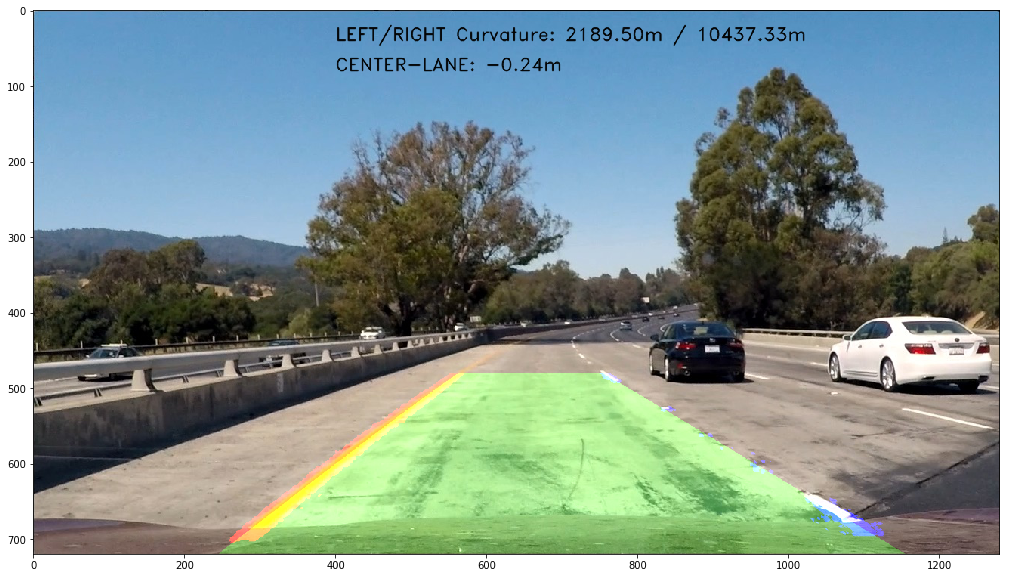

In [20]:
#######################################################################################################################
## Tips && tricks
#######################################################################################################################
## Filtering
#######################################################################################################################
def filtering_lane(lane):
    global prev_lanes
    good_line_diff = True
    good_lane_area = True
    
    # ? the total x-pixel difference between the new and the old
    if len(prev_lanes) > 0:  
        prev_x_left = prev_lanes[0].left_x_vals
        prev_x_right = prev_lanes[0].right_x_vals
        current_x_left = lane.left_x_vals
        current_x_right = lane.right_x_vals
        left_diff = np.sum(np.absolute(prev_x_left - current_x_left))
        right_diff = np.sum(np.absolute(prev_x_right - current_x_right))
        lane_pixel_margin = 50  # difference between new and old line 
        diff_threshold = lane_pixel_margin*len(prev_x_left)

        if left_diff > diff_threshold or right_diff > diff_threshold:
            print(diff_threshold, int(left_diff), int(right_diff))
            #print()
            good_line_diff = False
    
    # fix the area between the lane lines (check if is appropriate )
    lane_area = np.sum(np.absolute(np.subtract(lane.right_x_vals, lane.left_x_vals)))
    area_min, area_max = 400000, 800000 # a^2 thresholds
    if lane_area < area_min or lane_area > area_max:
        good_lane_area = False
    return (good_line_diff and good_lane_area)

#######################################################################################################################
## Smoothing
#######################################################################################################################
def smoothing_lane():
    global prev_lanes    
    if len(prev_lanes) == 0: return None
    elif len(prev_lanes) == 1: return prev_lanes[0]
    else:  
        n_lanes = len(prev_lanes)
        new_lane = prev_lanes[0]
        
        avg_lane = Lane() 
        avg_lane.y_vals = new_lane.y_vals
        avg_lane.lane_lines_img = new_lane.lane_lines_img

        # avg L&R lanes -> x-values
        left_avg = new_lane.left_x_vals
        right_avg = new_lane.right_x_vals
        for i in range(1, n_lanes):
            left_avg = np.add(left_avg, prev_lanes[i].left_x_vals)
            right_avg = np.add(right_avg, prev_lanes[i].right_x_vals)

        avg_lane.left_x_vals = left_avg / n_lanes
        avg_lane.right_x_vals = right_avg / n_lanes
        
        # avg the curvatures and offsets
        avg_lane.left_curvature = sum([lane.left_curvature for lane in prev_lanes])/n_lanes
        avg_lane.right_curvature = sum([lane.right_curvature for lane in prev_lanes])/n_lanes
        avg_lane.offset = sum([lane.offset for lane in prev_lanes])/n_lanes

        return avg_lane

#######################################################################################################################
## Advanced lane detection pipe (with filtering && smoothing)
#######################################################################################################################
def advanced_lane_detection_pipe(img, show=False):        
    global prev_lanes
    global n_bad_lanes
    
    if type(img) is str: img = mpimg.imread(img)
        
    n_lanes_to_keep = 5
    
    if len(prev_lanes) == n_lanes_to_keep and n_bad_lanes == 0:
        n_bad_lanes += 1
        return draw_lane(img, smoothing_lane(), show=show)
        
    undist = undistort_img(img)
    threshed = threshold_img(undist)
    warped, M, Minv = warp_to_lines(threshed)
    lane = find_lane(warped)
    
    if filtering_lane(lane):  
        n_bad_lanes = 0
        prev_lanes.insert(0, lane)
        if len(prev_lanes) > n_lanes_to_keep: prev_lanes.pop()
    else:
        n_bad_lanes += 1
        
    # If we get stuck on some bad lanes, don't reinforce it, just clear them out.
    if n_bad_lanes >= 12:        
        n_bad_lanes = 0
        prev_lanes = []
        
    # If we start with some bad lanes, this will just skip the drawing
    if len(prev_lanes) == 0: return img
            
    return draw_lane(img, smoothing_lane(), show=show)

# testing tips && trick (filtering && smoothing )
print('Testing filtering && smoothing')
n_bad_lanes = 0
prev_lanes = []
drawn_img = advanced_lane_detection_pipe('./test_images/test1.jpg', show=True)
cv2.imwrite('./output_images/filtering_smoothing_test.jpg', cv2.cvtColor(drawn_img, cv2.COLOR_RGB2BGR))

### Processing videos
It's time to test all with videos.
There are 3 videos stored in directory 'test_videos', the output processed videos will stored in directory 'output_videos'.

In [21]:
#######################################################################################################################
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# output_videos = {project_video.mp4, challenge_video.mp4, harder_challenge_video.mp4}
n_bad_lanes = 0
prev_lanes = []

video_name = 'project_video.mp4'
video = VideoFileClip('./test_videos/{}'.format(video_name))
video = video.fl_image(advanced_lane_detection_pipe)  
%time video.write_videofile('./output_videos/{}'.format(video_name), audio=False) 


[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


 44%|████▍     | 554/1261 [01:12<01:33,  7.52it/s]

36000 1993 102672


 44%|████▍     | 555/1261 [01:12<01:50,  6.38it/s]

36000 1260 95535


 44%|████▍     | 556/1261 [01:12<02:34,  4.56it/s]

36000 2283 96538


 46%|████▌     | 577/1261 [01:15<01:35,  7.18it/s]

36000 4187 380724
36000 6889 401826


 47%|████▋     | 589/1261 [01:17<01:36,  6.97it/s]

36000 1169 258467


 48%|████▊     | 602/1261 [01:19<01:33,  7.03it/s]

36000 7848 269268


 49%|████▊     | 613/1261 [01:21<01:30,  7.15it/s]

36000 1409 321427


 49%|████▊     | 614/1261 [01:21<01:46,  6.08it/s]

36000 2364 227935


 49%|████▉     | 615/1261 [01:21<02:19,  4.62it/s]

36000 2455 271296


 49%|████▉     | 616/1261 [01:21<02:26,  4.40it/s]

36000 4418 253882


 49%|████▉     | 617/1261 [01:22<02:34,  4.17it/s]

36000 6348 831992


 79%|███████▊  | 990/1261 [02:16<00:35,  7.70it/s]

36000 7696 306224


 79%|███████▉  | 1001/1261 [02:18<00:35,  7.35it/s]

36000 7619 175995


 79%|███████▉  | 1002/1261 [02:18<00:41,  6.31it/s]

36000 20047 185731


 80%|███████▉  | 1003/1261 [02:18<00:51,  4.96it/s]

36000 30012 72725


 80%|███████▉  | 1004/1261 [02:19<00:57,  4.48it/s]

36000 40755 196478


 80%|███████▉  | 1005/1261 [02:19<01:00,  4.25it/s]

36000 39488 32114


 82%|████████▏ | 1038/1261 [02:24<00:32,  6.94it/s]

36000 1509 252084


 83%|████████▎ | 1047/1261 [02:25<00:34,  6.12it/s]

36000 14636 303176


 83%|████████▎ | 1048/1261 [02:25<00:40,  5.28it/s]

36000 6208 315672


 83%|████████▎ | 1049/1261 [02:26<00:48,  4.33it/s]

36000 6465 262119


 83%|████████▎ | 1050/1261 [02:26<00:52,  4.03it/s]

36000 10564 63804


 83%|████████▎ | 1051/1261 [02:26<00:53,  3.96it/s]

36000 4822 97581


 91%|█████████ | 1150/1261 [02:39<00:14,  7.90it/s]

36000 2899 376579
36000 3920 377766


 91%|█████████▏| 1152/1261 [02:40<00:20,  5.33it/s]

36000 4739 380980


 91%|█████████▏| 1153/1261 [02:40<00:21,  5.07it/s]

36000 4635 382852


 92%|█████████▏| 1154/1261 [02:40<00:24,  4.37it/s]

36000 9395 387612


100%|█████████▉| 1260/1261 [02:54<00:00,  7.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 2min 50s, sys: 31 s, total: 3min 21s
Wall time: 2min 55s


In [136]:
n_bad_lanes = 0
prev_lanes = []

video_name = 'challenge_video.mp4'
video = VideoFileClip('./test_videos/{}'.format(video_name))
video = video.fl_image(advanced_lane_detection_pipe)  
%time video.write_videofile('./output_videos/{}'.format(video_name), audio=False) 

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4



 13%|█▎        | 64/485 [00:09<01:09,  6.04it/s]

36000 3880 176225



 13%|█▎        | 65/485 [00:09<01:21,  5.18it/s]

36000 959 174452



 14%|█▎        | 66/485 [00:10<01:32,  4.55it/s]

36000 4222 174568



 14%|█▍        | 67/485 [00:10<01:38,  4.23it/s]

36000 5734 175736



 14%|█▍        | 68/485 [00:10<01:41,  4.11it/s]

36000 4470 174238



 14%|█▍        | 69/485 [00:10<01:51,  3.74it/s]

36000 4753 170267



 14%|█▍        | 70/485 [00:11<01:45,  3.94it/s]

36000 12029 168929



 15%|█▍        | 71/485 [00:11<01:53,  3.66it/s]

36000 16163 167520



 15%|█▍        | 72/485 [00:11<01:56,  3.55it/s]

36000 9254 164203



 15%|█▌        | 73/485 [00:12<02:06,  3.26it/s]

36000 12484 161888



 15%|█▌        | 74/485 [00:12<02:09,  3.18it/s]

36000 12642 159049
Resetting: too many bad lanes.



 19%|█▉        | 91/485 [00:15<01:12,  5.45it/s]

36000 5799 241863



 19%|█▉        | 92/485 [00:16<01:37,  4.01it/s]

36000 4051 240927



 22%|██▏       | 105/485 [00:18<01:24,  4.51it/s]

36000 2830 245624



 22%|██▏       | 106/485 [00:19<01:49,  3.46it/s]

36000 7580 246457



 22%|██▏       | 107/485 [00:19<01:52,  3.35it/s]

36000 7186 247227



 24%|██▍       | 118/485 [00:21<01:17,  4.72it/s]

36000 3827 253916



 25%|██▍       | 119/485 [00:22<01:30,  4.06it/s]

36000 8277 253829



 25%|██▍       | 120/485 [00:22<01:45,  3.46it/s]

36000 4808 254060



 25%|██▍       | 121/485 [00:22<01:45,  3.45it/s]

36000 6169 254502



 26%|██▌       | 127/485 [00:23<01:05,  5.45it/s]

36000 9461 94840



 27%|██▋       | 133/485 [00:24<00:53,  6.56it/s]

36000 8429 263019
36000 32249 265260



 28%|██▊       | 135/485 [00:25<01:14,  4.67it/s]

36000 43818 263841



 28%|██▊       | 136/485 [00:25<01:26,  4.03it/s]

36000 81600 260370



 28%|██▊       | 137/485 [00:25<01:21,  4.28it/s]

36000 80036 262654



 28%|██▊       | 138/485 [00:25<01:21,  4.26it/s]

36000 203844 260933



 29%|██▊       | 139/485 [00:26<01:21,  4.23it/s]

36000 236091 260686
36000 239086 260269



 29%|██▉       | 142/485 [00:26<01:16,  4.47it/s]

36000 231932 260208
36000 45210 260493



 30%|██▉       | 144/485 [00:27<01:05,  5.20it/s]

36000 29358 259943
Resetting: too many bad lanes.



 31%|███▏      | 152/485 [00:28<01:13,  4.54it/s]

36000 1333 237645



 32%|███▏      | 154/485 [00:29<01:06,  4.96it/s]

36000 1786 236214
36000 4412 236837



 32%|███▏      | 156/485 [00:29<01:04,  5.11it/s]

36000 5978 237113



 32%|███▏      | 157/485 [00:29<01:12,  4.54it/s]

36000 8235 237231



 33%|███▎      | 158/485 [00:30<01:13,  4.46it/s]

36000 9056 237428
36000 11157 237768



 33%|███▎      | 160/485 [00:30<01:08,  4.72it/s]

36000 9718 237782



 33%|███▎      | 161/485 [00:30<01:11,  4.51it/s]

36000 12599 238262



 33%|███▎      | 162/485 [00:30<01:13,  4.42it/s]

36000 13871 238463
36000 13823 238568



 36%|███▌      | 173/485 [00:32<00:52,  5.94it/s]

36000 5537 232612
36000 7087 233233



 36%|███▌      | 175/485 [00:33<00:56,  5.53it/s]

36000 10730 233754



 38%|███▊      | 186/485 [00:34<00:39,  7.62it/s]

36000 6489 244686
36000 8607 244952



 39%|███▉      | 188/485 [00:35<00:59,  4.97it/s]

36000 9099 244771



 39%|███▉      | 189/485 [00:35<01:17,  3.81it/s]

36000 9920 244253



 39%|███▉      | 190/485 [00:35<01:18,  3.75it/s]

36000 10253 244329



 40%|████      | 195/485 [00:36<00:58,  4.95it/s]

36000 3590 239862



 40%|████      | 196/485 [00:36<01:02,  4.65it/s]

36000 6600 239641



 41%|████      | 197/485 [00:37<01:04,  4.49it/s]

36000 7042 238865



 41%|████      | 200/485 [00:37<00:59,  4.79it/s]

36000 1657 233640
36000 2259 232843



 42%|████▏     | 202/485 [00:37<00:55,  5.06it/s]

36000 2991 233785



 44%|████▍     | 213/485 [00:39<00:41,  6.52it/s]

36000 3688 228581



 44%|████▍     | 214/485 [00:39<00:46,  5.82it/s]

36000 2817 228675
36000 6033 228465



 45%|████▍     | 216/485 [00:40<00:55,  4.83it/s]

36000 8924 228352



 45%|████▍     | 217/485 [00:40<00:55,  4.84it/s]

36000 5755 227596



 47%|████▋     | 228/485 [00:42<00:34,  7.49it/s]

36000 1145 225460



 47%|████▋     | 229/485 [00:42<00:46,  5.53it/s]

36000 1633 225558



 47%|████▋     | 230/485 [00:42<00:48,  5.23it/s]

36000 2124 225934



 50%|█████     | 243/485 [00:44<00:33,  7.13it/s]

36000 2420 220629



 50%|█████     | 244/485 [00:44<00:39,  6.17it/s]

36000 4001 220564



 53%|█████▎    | 255/485 [00:46<00:31,  7.39it/s]

36000 3425 231242



 53%|█████▎    | 256/485 [00:46<00:36,  6.30it/s]

36000 4736 231452



 53%|█████▎    | 257/485 [00:46<00:40,  5.69it/s]

36000 5049 231137
36000 5385 231143



 55%|█████▌    | 269/485 [00:48<00:30,  7.01it/s]

36000 4097 233679
36000 5887 233967



 56%|█████▌    | 272/485 [00:48<00:35,  5.97it/s]

36000 3830 233734
36000 3578 233859



 59%|█████▉    | 285/485 [00:50<00:26,  7.65it/s]

36000 5293 222927



 61%|██████▏   | 298/485 [00:52<00:22,  8.15it/s]

36000 3671 230565
36000 6555 231302



 62%|██████▏   | 300/485 [00:52<00:29,  6.30it/s]

36000 8247 231476



 64%|██████▍   | 311/485 [00:54<00:28,  6.19it/s]

36000 2794 224889



 64%|██████▍   | 312/485 [00:54<00:33,  5.17it/s]

36000 5060 224582



 65%|██████▍   | 313/485 [00:54<00:33,  5.13it/s]

36000 3972 224740
36000 8132 224808



 67%|██████▋   | 325/485 [00:56<00:23,  6.72it/s]

36000 2223 229937
36000 2585 228736



 67%|██████▋   | 327/485 [00:56<00:26,  6.02it/s]

36000 2207 229510



 68%|██████▊   | 332/485 [00:57<00:22,  6.68it/s]

36000 2393 226474



 69%|██████▊   | 333/485 [00:57<00:25,  5.92it/s]

36000 1875 227902
36000


 69%|██████▉   | 335/485 [00:58<00:27,  5.50it/s]

 3682 228230
36000 4299 228813



 70%|██████▉   | 338/485 [00:58<00:25,  5.86it/s]

36000 4695 226906
36000 4688 225570



 70%|███████   | 340/485 [00:59<00:26,  5.55it/s]

36000 3620 223180



 70%|███████   | 341/485 [00:59<00:29,  4.91it/s]

36000 6861 225120
36000 8499 226365



 72%|███████▏  | 347/485 [01:00<00:24,  5.63it/s]

36000 2525 234162
36000


 72%|███████▏  | 349/485 [01:00<00:24,  5.49it/s]

 4618 235395
36000 3488 236233



 73%|███████▎  | 352/485 [01:01<00:24,  5.51it/s]

36000 1983 221531
36000 3985 221512



 73%|███████▎  | 354/485 [01:01<00:24,  5.34it/s]

36000 3030 221745



 73%|███████▎  | 355/485 [01:01<00:25,  5.11it/s]

36000 3606 221872
36000 2509 221992



 74%|███████▎  | 357/485 [01:02<00:24,  5.25it/s]

36000 3484 222596
36000


 74%|███████▍  | 359/485 [01:02<00:24,  5.15it/s]

 2815 223185
36000 3837 223439
36000 3067 225176



 75%|███████▍  | 362/485 [01:03<00:22,  5.35it/s]

36000 4069 225820
36000 2310 227323
Resetting: too many bad lanes.



 77%|███████▋  | 374/485 [01:05<00:21,  5.20it/s]

Resetting: too many bad lanes.



 82%|████████▏ | 400/485 [01:10<00:14,  5.85it/s]

36000 200211 1392



 83%|████████▎ | 401/485 [01:10<00:15,  5.46it/s]

36000 198609 3555



 87%|████████▋ | 422/485 [01:13<00:09,  6.47it/s]

36000 124681 8480



 88%|████████▊ | 427/485 [01:14<00:10,  5.38it/s]

36000 119714 5689



 88%|████████▊ | 428/485 [01:15<00:13,  4.26it/s]

36000 117997 7860



 88%|████████▊ | 429/485 [01:15<00:14,  3.80it/s]

36000 115070 8051



 89%|████████▊ | 430/485 [01:15<00:13,  3.98it/s]

36000 109891 2395



 89%|████████▉ | 431/485 [01:15<00:12,  4.21it/s]

36000 106436 4488



 89%|████████▉ | 432/485 [01:16<00:14,  3.71it/s]

36000 100133 6012



 89%|████████▉ | 433/485 [01:16<00:15,  3.37it/s]

36000 95022 9288



 89%|████████▉ | 434/485 [01:16<00:16,  3.18it/s]

36000 91499 10387



 93%|█████████▎| 451/485 [01:19<00:05,  6.37it/s]

36000 1963 769706



 96%|█████████▌| 464/485 [01:22<00:03,  5.64it/s]

36000 3731 375015



 96%|█████████▌| 465/485 [01:22<00:03,  5.24it/s]

36000 5730 616575



 96%|█████████▌| 466/485 [01:22<00:03,  4.80it/s]

36000 7244 57654



 98%|█████████▊| 477/485 [01:24<00:01,  7.03it/s]

36000 1970 1045959



 99%|█████████▊| 478/485 [01:24<00:01,  6.00it/s]

36000 4529 1122281



 99%|█████████▉| 479/485 [01:24<00:01,  5.50it/s]

36000 4094 867568



 99%|█████████▉| 480/485 [01:24<00:00,  5.16it/s]

36000 5604 1010050



100%|██████████| 485/485 [01:25<00:00,  6.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

CPU times: user 1min 16s, sys: 15.7 s, total: 1min 32s
Wall time: 1min 26s


In [137]:
n_bad_lanes = 0
prev_lanes = []

video_name = 'harder_challenge_video.mp4'
video = VideoFileClip('./test_videos/{}'.format(video_name))
video = video.fl_image(advanced_lane_detection_pipe)  
%time video.write_videofile('./output_videos/{}'.format(video_name), audio=False) 

[MoviePy] >>>> Building video ./output_videos/harder_challenge_video.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video.mp4



  4%|▍         | 46/1200 [00:06<02:46,  6.95it/s]

36000 6338 200017



  4%|▍         | 47/1200 [00:06<03:28,  5.54it/s]

36000 9237 201095



  4%|▍         | 48/1200 [00:07<04:07,  4.65it/s]

36000 10121 205811



  4%|▍         | 49/1200 [00:07<04:20,  4.41it/s]

36000 11684 204369



  4%|▍         | 50/1200 [00:07<04:34,  4.19it/s]

36000 13136 199674



  4%|▍         | 51/1200 [00:07<04:38,  4.13it/s]

36000 15496 197459



  4%|▍         | 52/1200 [00:08<04:44,  4.03it/s]

36000 16951 201086



  4%|▍         | 53/1200 [00:08<04:44,  4.04it/s]

36000 19838 195780



  4%|▍         | 54/1200 [00:08<04:49,  3.96it/s]

36000 24315 195281



  5%|▍         | 55/1200 [00:09<04:46,  4.00it/s]

36000 25092 199854



  5%|▍         | 56/1200 [00:09<04:41,  4.07it/s]

36000 29027 193206
Resetting: too many bad lanes.



  6%|▌         | 68/1200 [00:12<04:25,  4.27it/s]

Resetting: too many bad lanes.



  7%|▋         | 82/1200 [00:15<04:27,  4.18it/s]

36000 46335 7210



  7%|▋         | 83/1200 [00:15<04:27,  4.17it/s]

36000 77013 13234



  7%|▋         | 84/1200 [00:16<05:39,  3.29it/s]

36000 73429 14180



  7%|▋         | 85/1200 [00:16<05:49,  3.19it/s]

36000 72032 5889



  7%|▋         | 86/1200 [00:16<05:34,  3.34it/s]

36000 66401 11989



  7%|▋         | 87/1200 [00:16<05:34,  3.32it/s]

36000 52126 13365



  7%|▋         | 88/1200 [00:17<05:47,  3.20it/s]

36000 90989 19175



  7%|▋         | 89/1200 [00:17<05:33,  3.33it/s]

36000 189647 15227



  8%|▊         | 90/1200 [00:17<05:14,  3.53it/s]

36000 195719 28460



  8%|▊         | 91/1200 [00:18<04:55,  3.76it/s]

36000 197334 26952



  8%|▊         | 92/1200 [00:18<04:55,  3.75it/s]

36000 192418 34801



  8%|▊         | 93/1200 [00:18<04:40,  3.95it/s]

36000 187896 43532
Resetting: too many bad lanes.



  8%|▊         | 100/1200 [00:20<04:52,  3.76it/s]

36000 100568 17614



  8%|▊         | 101/1200 [00:20<05:04,  3.61it/s]

36000 85724 131573



  8%|▊         | 102/1200 [00:20<04:51,  3.76it/s]

36000 63573 135615



  9%|▊         | 103/1200 [00:21<05:17,  3.46it/s]

36000 64505 143345



  9%|▊         | 104/1200 [00:21<05:28,  3.34it/s]

36000 53700 146704



  9%|▉         | 105/1200 [00:21<05:50,  3.12it/s]

36000 43390 147205



  9%|▉         | 106/1200 [00:22<05:58,  3.05it/s]

36000 35436 148126



  9%|▉         | 107/1200 [00:22<05:55,  3.08it/s]

36000 32563 113440



  9%|▉         | 108/1200 [00:22<05:58,  3.05it/s]

36000 73284 120219



  9%|▉         | 109/1200 [00:23<05:35,  3.25it/s]

36000 62238 138885



  9%|▉         | 110/1200 [00:23<05:37,  3.23it/s]

36000 57002 141189
Resetting: too many bad lanes.



 10%|▉         | 116/1200 [00:25<05:11,  3.48it/s]

36000 7760 130590



 10%|▉         | 117/1200 [00:25<05:34,  3.24it/s]

36000 28098 235804



 10%|▉         | 118/1200 [00:25<05:39,  3.19it/s]

36000 21009 225291



 10%|▉         | 119/1200 [00:26<05:50,  3.08it/s]

36000 32666 215595



 10%|█         | 120/1200 [00:26<06:00,  3.00it/s]

36000 19470 205441



 10%|█         | 121/1200 [00:26<05:51,  3.07it/s]

36000 21234 195499



 10%|█         | 122/1200 [00:27<05:31,  3.25it/s]

36000 4534 200315



 10%|█         | 123/1200 [00:27<05:14,  3.43it/s]

36000 15000 189497



 10%|█         | 124/1200 [00:27<05:32,  3.24it/s]

36000 23107 186252



 10%|█         | 125/1200 [00:27<05:12,  3.44it/s]

36000 34743 171637



 10%|█         | 126/1200 [00:28<04:57,  3.61it/s]

36000 42297 155784



 11%|█         | 127/1200 [00:28<04:48,  3.72it/s]

36000 51512 138009
Resetting: too many bad lanes.



 11%|█         | 134/1200 [00:29<03:57,  4.48it/s]

36000 14213 56821



 11%|█▏        | 135/1200 [00:30<03:55,  4.51it/s]

36000 23578 95645



 11%|█▏        | 136/1200 [00:30<04:14,  4.17it/s]

36000 30683 110719



 11%|█▏        | 137/1200 [00:30<04:15,  4.16it/s]

36000 35598 123791



 12%|█▏        | 138/1200 [00:30<04:04,  4.35it/s]

36000 40849 138164



 12%|█▏        | 139/1200 [00:31<03:56,  4.48it/s]

36000 46465 152554



 12%|█▏        | 140/1200 [00:31<03:54,  4.51it/s]

36000 57546 163920



 12%|█▏        | 141/1200 [00:31<03:56,  4.48it/s]

36000 61609 174159



 12%|█▏        | 142/1200 [00:31<03:54,  4.52it/s]

36000 70861 183008



 12%|█▏        | 143/1200 [00:32<03:52,  4.56it/s]

36000 78101 193082



 12%|█▏        | 144/1200 [00:32<03:42,  4.74it/s]

36000 83917 205708
Resetting: too many bad lanes.



 13%|█▎        | 151/1200 [00:33<03:07,  5.58it/s]

36000 3230 257453
36000 9799 39849



 13%|█▎        | 153/1200 [00:33<03:23,  5.15it/s]

36000 28929 47463
36000 5826 402811



 13%|█▎        | 155/1200 [00:34<03:26,  5.07it/s]

36000 9145 421860
36000 11760 421459



 13%|█▎        | 157/1200 [00:34<03:25,  5.07it/s]

36000 35575 53824



 13%|█▎        | 158/1200 [00:34<03:31,  4.94it/s]

36000 10903 409344



 13%|█▎        | 159/1200 [00:35<03:31,  4.92it/s]

36000 13352 392311
36000


 14%|█▎        | 162/1200 [00:35<03:21,  5.15it/s]

 80509 104280
36000 67819 737149
Resetting: too many bad lanes.



 14%|█▍        | 167/1200 [00:36<03:16,  5.25it/s]

36000 50046 948073
36000 31390 1156886



 14%|█▍        | 169/1200 [00:37<03:18,  5.19it/s]

36000 113164 120489
36000 74853 811032



 14%|█▍        | 171/1200 [00:37<03:19,  5.16it/s]

36000 117784 110227
36000 73547 159912



 14%|█▍        | 172/1200 [00:37<03:19,  5.15it/s]

36000 103828 243696
36000 149460 8218



 15%|█▍        | 175/1200 [00:38<03:14,  5.27it/s]

36000 182996 438353
36000 174894 447979



 15%|█▍        | 177/1200 [00:38<03:09,  5.39it/s]

36000 127928 443603
36000 174777 445781
Resetting: too many bad lanes.



 16%|█▌        | 189/1200 [00:40<03:28,  4.86it/s]

Resetting: too many bad lanes.



 16%|█▋        | 198/1200 [00:42<03:42,  4.50it/s]

36000 114643 14623



 17%|█▋        | 199/1200 [00:43<03:38,  4.58it/s]

36000 98800 3156



 17%|█▋        | 200/1200 [00:43<03:50,  4.34it/s]

36000 93029 413450



 17%|█▋        | 201/1200 [00:43<03:48,  4.37it/s]

36000 112890 8536



 17%|█▋        | 202/1200 [00:44<04:33,  3.65it/s]

36000 89881 26421



 17%|█▋        | 203/1200 [00:44<06:01,  2.76it/s]

36000 99910 11997



 17%|█▋        | 204/1200 [00:45<06:35,  2.52it/s]

36000 94598 28756



 17%|█▋        | 205/1200 [00:45<06:40,  2.48it/s]

36000 80785 10061



 17%|█▋        | 206/1200 [00:45<07:10,  2.31it/s]

36000 67040 14389



 17%|█▋        | 207/1200 [00:46<07:31,  2.20it/s]

36000 54050 19037



 17%|█▋        | 208/1200 [00:46<07:41,  2.15it/s]

36000 39776 24830



 18%|█▊        | 222/1200 [00:52<05:49,  2.80it/s]

36000 18649 130367



 19%|█▉        | 225/1200 [00:53<05:33,  2.93it/s]

36000 3154 116801



 19%|█▉        | 226/1200 [00:54<06:14,  2.60it/s]

36000 3994 118808



 19%|█▉        | 227/1200 [00:54<07:13,  2.24it/s]

36000 3969 137201



 19%|█▉        | 228/1200 [00:55<06:59,  2.31it/s]

36000 4694 129156



 19%|█▉        | 229/1200 [00:55<06:34,  2.46it/s]

36000 15668 122146



 19%|█▉        | 230/1200 [00:55<06:38,  2.44it/s]

36000 9438 120201



 19%|█▉        | 231/1200 [00:56<06:57,  2.32it/s]

36000 10726 127033



 19%|█▉        | 232/1200 [00:56<07:08,  2.26it/s]

36000 9166 137359



 19%|█▉        | 233/1200 [00:57<07:27,  2.16it/s]

36000 8371 129644



 20%|█▉        | 234/1200 [00:57<07:41,  2.09it/s]

36000 96802 136485



 20%|█▉        | 235/1200 [00:58<07:12,  2.23it/s]

36000 93766 139574
Resetting: too many bad lanes.



 20%|██        | 244/1200 [01:01<06:38,  2.40it/s]

36000 45099 6816



 21%|██        | 248/1200 [01:03<06:22,  2.49it/s]

36000 63688 6100



 21%|██        | 249/1200 [01:03<06:27,  2.45it/s]

36000 65615 10753



 21%|██        | 250/1200 [01:04<06:10,  2.57it/s]

36000 73519 4501



 21%|██        | 251/1200 [01:04<05:50,  2.71it/s]

36000 79238 8343



 21%|██        | 252/1200 [01:04<06:02,  2.62it/s]

36000 89251 15964



 21%|██        | 253/1200 [01:05<05:33,  2.84it/s]

36000 72137 23768



 21%|██        | 254/1200 [01:05<05:17,  2.98it/s]

36000 64861 14606



 21%|██▏       | 255/1200 [01:05<05:14,  3.00it/s]

36000 54114 9910



 21%|██▏       | 256/1200 [01:06<05:15,  2.99it/s]

36000 62151 8932



 21%|██▏       | 257/1200 [01:06<05:18,  2.96it/s]

36000 77407 26062



 22%|██▏       | 258/1200 [01:06<05:12,  3.02it/s]

36000 94285 13897
Resetting: too many bad lanes.



 22%|██▏       | 260/1200 [01:07<05:05,  3.08it/s]

36000 158042 7367



 22%|██▏       | 261/1200 [01:07<04:52,  3.21it/s]

36000 98834 7580



 22%|██▏       | 262/1200 [01:08<04:43,  3.31it/s]

36000 60652 17211



 22%|██▏       | 263/1200 [01:08<05:01,  3.11it/s]

36000 47362 4344



 22%|██▏       | 264/1200 [01:08<04:57,  3.15it/s]

36000 78365 22487



 22%|██▎       | 270/1200 [01:10<04:52,  3.18it/s]

36000 16189 80098



 23%|██▎       | 271/1200 [01:10<04:59,  3.10it/s]

36000 14509 73130



 24%|██▎       | 282/1200 [01:13<03:18,  4.64it/s]

36000 78493 15473



 24%|██▎       | 283/1200 [01:13<03:36,  4.24it/s]

36000 83880 32901



 24%|██▎       | 284/1200 [01:13<04:02,  3.78it/s]

36000 86980 40464



 24%|██▍       | 285/1200 [01:14<03:57,  3.85it/s]

36000 83718 53279



 24%|██▍       | 286/1200 [01:14<03:55,  3.88it/s]

36000 75164 68266



 24%|██▍       | 287/1200 [01:14<04:16,  3.57it/s]

36000 75691 76636



 24%|██▍       | 288/1200 [01:14<04:29,  3.38it/s]

36000 70992 87985



 24%|██▍       | 289/1200 [01:15<04:17,  3.54it/s]

36000 43592 98160



 24%|██▍       | 290/1200 [01:15<04:27,  3.40it/s]

36000 48784 120481



 24%|██▍       | 291/1200 [01:15<04:58,  3.05it/s]

36000 43171 133176



 24%|██▍       | 292/1200 [01:16<04:59,  3.03it/s]

36000 43119 145984
Resetting: too many bad lanes.



 25%|██▍       | 296/1200 [01:17<04:18,  3.50it/s]

36000 2780 48934



 25%|██▌       | 300/1200 [01:18<03:34,  4.19it/s]

36000 10010 189518



 25%|██▌       | 301/1200 [01:18<04:00,  3.74it/s]

36000 14984 176059



 25%|██▌       | 302/1200 [01:18<04:02,  3.70it/s]

36000 14980 163346



 25%|██▌       | 303/1200 [01:19<04:11,  3.57it/s]

36000 13028 152038



 25%|██▌       | 304/1200 [01:19<04:02,  3.70it/s]

36000 19675 144733



 25%|██▌       | 305/1200 [01:19<04:09,  3.58it/s]

36000 23618 139875



 26%|██▌       | 306/1200 [01:19<04:03,  3.68it/s]

36000 28619 134422



 26%|██▌       | 307/1200 [01:20<03:49,  3.89it/s]

36000 33973 132749



 26%|██▌       | 308/1200 [01:20<04:04,  3.65it/s]

36000 36741 129916



 26%|██▌       | 309/1200 [01:20<04:00,  3.70it/s]

36000 48171 124375



 26%|██▌       | 310/1200 [01:20<03:47,  3.92it/s]

36000 45924 117904
Resetting: too many bad lanes.



 27%|██▋       | 327/1200 [01:23<02:05,  6.94it/s]

36000 8291 50202



 28%|██▊       | 338/1200 [01:25<02:01,  7.07it/s]

36000 3840 64539



 28%|██▊       | 339/1200 [01:25<02:33,  5.63it/s]

36000 4109 48519



 28%|██▊       | 340/1200 [01:25<03:04,  4.66it/s]

36000 8411 45617



 28%|██▊       | 341/1200 [01:26<03:08,  4.55it/s]

36000 14091 45883



 28%|██▊       | 342/1200 [01:26<03:40,  3.89it/s]

36000 19911 50797



 29%|██▊       | 343/1200 [01:26<03:35,  3.98it/s]

36000 18879 66758



 29%|██▉       | 350/1200 [01:27<02:46,  5.12it/s]

36000 10067 92343



 29%|██▉       | 351/1200 [01:28<02:53,  4.89it/s]

36000 6046 180769



 29%|██▉       | 352/1200 [01:28<02:59,  4.73it/s]

36000 13329 329123



 29%|██▉       | 353/1200 [01:28<03:16,  4.32it/s]

36000 10184 361537



 30%|██▉       | 354/1200 [01:28<03:20,  4.22it/s]

36000 14560 197914



 30%|██▉       | 355/1200 [01:29<03:19,  4.23it/s]

36000 11976 153089



 30%|██▉       | 356/1200 [01:29<03:27,  4.07it/s]

36000 12863 96788



 30%|██▉       | 357/1200 [01:29<03:38,  3.85it/s]

36000 24336 99592



 30%|██▉       | 358/1200 [01:29<03:34,  3.93it/s]

36000 25982 86019



 30%|██▉       | 359/1200 [01:30<03:27,  4.05it/s]

36000 30390 95898



 30%|███       | 360/1200 [01:30<03:16,  4.28it/s]

36000 33622 87890
Resetting: too many bad lanes.



 31%|███       | 367/1200 [01:31<02:48,  4.94it/s]

36000 65781 358421



 31%|███       | 368/1200 [01:31<02:53,  4.79it/s]

36000 72072 368287



 31%|███       | 369/1200 [01:32<03:06,  4.47it/s]

36000 24849 341373



 31%|███       | 370/1200 [01:32<03:08,  4.41it/s]

36000 93395 10218



 31%|███       | 373/1200 [01:33<02:51,  4.81it/s]

36000 14067 95675



 33%|███▎      | 394/1200 [01:36<02:14,  5.97it/s]

36000 12784 132928



 33%|███▎      | 395/1200 [01:36<02:48,  4.77it/s]

36000 24233 133525



 33%|███▎      | 396/1200 [01:37<03:01,  4.43it/s]

36000 33921 133029



 33%|███▎      | 397/1200 [01:37<03:09,  4.24it/s]

36000 39574 132006



 33%|███▎      | 398/1200 [01:37<03:18,  4.04it/s]

36000 45244 131845



 33%|███▎      | 399/1200 [01:37<03:22,  3.97it/s]

36000 56009 18628



 33%|███▎      | 400/1200 [01:38<03:21,  3.96it/s]

36000 65698 14550



 33%|███▎      | 401/1200 [01:38<03:22,  3.95it/s]

36000 74255 12706



 34%|███▎      | 402/1200 [01:38<03:19,  4.00it/s]

36000 80591 10665



 34%|███▎      | 403/1200 [01:38<03:17,  4.03it/s]

36000 74745 9771



 34%|███▎      | 404/1200 [01:39<03:11,  4.15it/s]

36000 83257 9564
Resetting: too many bad lanes.



 34%|███▍      | 406/1200 [01:39<03:13,  4.09it/s]

36000 8982 144518



 34%|███▍      | 407/1200 [01:40<03:45,  3.52it/s]

36000 30468 112143



 34%|███▍      | 408/1200 [01:40<03:43,  3.55it/s]

36000 26878 119394



 34%|███▍      | 409/1200 [01:40<04:05,  3.22it/s]

36000 36786 120290



 34%|███▍      | 410/1200 [01:40<03:53,  3.38it/s]

36000 20483 124418



 34%|███▍      | 411/1200 [01:41<03:50,  3.43it/s]

36000 23345 132111



 34%|███▍      | 412/1200 [01:41<03:51,  3.40it/s]

36000 41059 136516



 34%|███▍      | 413/1200 [01:42<04:39,  2.82it/s]

36000 41760 132031



 34%|███▍      | 414/1200 [01:42<05:11,  2.52it/s]

36000 41357 125437



 35%|███▍      | 415/1200 [01:42<04:56,  2.64it/s]

36000 35439 134799



 35%|███▍      | 416/1200 [01:43<04:53,  2.67it/s]

36000 51384 135212



 35%|███▍      | 417/1200 [01:43<04:30,  2.90it/s]

36000 61607 130215
Resetting: too many bad lanes.



 35%|███▌      | 422/1200 [01:45<05:13,  2.48it/s]

36000 178463 781



 35%|███▌      | 423/1200 [01:45<05:06,  2.54it/s]

36000 179921 1836



 35%|███▌      | 424/1200 [01:46<04:53,  2.65it/s]

36000 198023 2101



 35%|███▌      | 425/1200 [01:46<04:44,  2.72it/s]

36000 212361 2823



 36%|███▌      | 426/1200 [01:47<05:15,  2.45it/s]

36000 217601 2189



 36%|███▌      | 427/1200 [01:47<05:21,  2.40it/s]

36000 233683 7286



 36%|███▌      | 428/1200 [01:47<05:05,  2.53it/s]

36000 246523 4302



 36%|███▌      | 429/1200 [01:48<04:37,  2.78it/s]

36000 222060 6139



 36%|███▌      | 430/1200 [01:48<04:15,  3.02it/s]

36000 229128 7065



 36%|███▌      | 431/1200 [01:49<05:53,  2.17it/s]

36000 230432 7017



 36%|███▌      | 432/1200 [01:49<06:28,  1.98it/s]

36000 222491 6764



 36%|███▌      | 433/1200 [01:50<06:03,  2.11it/s]

36000 234769 8132
Resetting: too many bad lanes.



 37%|███▋      | 449/1200 [01:57<04:28,  2.80it/s]

36000 3506 224675



 38%|███▊      | 450/1200 [01:57<04:14,  2.94it/s]

36000 3841 216733



 38%|███▊      | 451/1200 [01:57<04:03,  3.08it/s]

36000 6816 196078



 38%|███▊      | 452/1200 [01:58<04:03,  3.07it/s]

36000 7710 170908



 38%|███▊      | 453/1200 [01:58<04:09,  3.00it/s]

36000 8588 159052



 38%|███▊      | 454/1200 [01:58<03:54,  3.18it/s]

36000 7818 165799



 38%|███▊      | 455/1200 [01:59<03:56,  3.15it/s]

36000 9675 183268



 38%|███▊      | 456/1200 [01:59<03:42,  3.34it/s]

36000 11609 168066



 38%|███▊      | 457/1200 [01:59<03:28,  3.57it/s]

36000 12252 163209
Resetting: too many bad lanes.



 38%|███▊      | 460/1200 [02:00<03:16,  3.76it/s]

36000 3581 155479



 38%|███▊      | 461/1200 [02:00<03:08,  3.91it/s]

36000 3562 147242



 39%|███▊      | 463/1200 [02:01<03:00,  4.07it/s]

36000 2545 160886
36000 15987 148704



 39%|███▉      | 465/1200 [02:01<02:43,  4.49it/s]

36000 18056 259626



 39%|███▉      | 466/1200 [02:01<02:42,  4.53it/s]

36000 21864 259169



 39%|███▉      | 467/1200 [02:01<02:42,  4.51it/s]

36000 25647 263747



 39%|███▉      | 468/1200 [02:02<02:41,  4.53it/s]

36000 26257 253343



 39%|███▉      | 469/1200 [02:02<02:43,  4.47it/s]

36000 29094 248493



 39%|███▉      | 470/1200 [02:02<02:43,  4.48it/s]

36000 175258 240234



 39%|███▉      | 471/1200 [02:02<02:42,  4.49it/s]

36000 164830 231886



 39%|███▉      | 472/1200 [02:03<02:40,  4.53it/s]

36000 122934 221794



 39%|███▉      | 473/1200 [02:03<02:47,  4.33it/s]

36000 148736 234785
36000


 40%|███▉      | 476/1200 [02:03<02:32,  4.74it/s]

 146608 222724
Resetting: too many bad lanes.
36000 42652 7628
36000 140761 44049



 40%|███▉      | 478/1200 [02:04<02:30,  4.79it/s]

36000 30151 47380
36000 121927 32428



 40%|████      | 480/1200 [02:04<02:30,  4.80it/s]

36000 138450 31128
36000 62544 55918



 40%|████      | 482/1200 [02:05<02:29,  4.79it/s]

36000 82604 59272
36000 46975 59173



 40%|████      | 484/1200 [02:05<02:25,  4.93it/s]

36000 43510 54228



 40%|████      | 485/1200 [02:05<02:27,  4.84it/s]

36000 39853 76647



 40%|████      | 486/1200 [02:05<02:30,  4.76it/s]

36000 66090 75671



 41%|████      | 487/1200 [02:06<02:27,  4.83it/s]

36000 47699 86892
Resetting: too many bad lanes.



 41%|████      | 489/1200 [02:06<02:30,  4.73it/s]

36000 59515 1723



 41%|████      | 491/1200 [02:07<02:32,  4.64it/s]

36000 101731 2079



 41%|████      | 493/1200 [02:07<02:24,  4.90it/s]

36000 128012 6915
36000 96321 17470



 42%|████▏     | 500/1200 [02:08<01:55,  6.06it/s]

36000 92484 37492
36000 52209 36926



 42%|████▏     | 502/1200 [02:08<02:11,  5.29it/s]

36000 55801 12707



 42%|████▏     | 503/1200 [02:09<02:17,  5.07it/s]

36000 84925 16840



 42%|████▏     | 504/1200 [02:09<02:25,  4.79it/s]

36000 104114 43890



 42%|████▏     | 505/1200 [02:09<02:29,  4.66it/s]

36000 75988 44008



 42%|████▏     | 506/1200 [02:09<02:32,  4.54it/s]

36000 61549 25373



 42%|████▏     | 507/1200 [02:10<02:34,  4.50it/s]

36000 86379 27408



 42%|████▏     | 508/1200 [02:10<02:34,  4.49it/s]

36000 75066 26376



 42%|████▏     | 509/1200 [02:10<02:35,  4.43it/s]

36000 92633 25547



 42%|████▎     | 510/1200 [02:10<02:34,  4.48it/s]

36000 101890 25186
Resetting: too many bad lanes.



 48%|████▊     | 579/1200 [02:21<01:37,  6.35it/s]

36000 283292 4803



 48%|████▊     | 582/1200 [02:21<01:51,  5.52it/s]

36000 176324 3027



 49%|████▉     | 585/1200 [02:22<01:58,  5.19it/s]

36000 133910 1285



 49%|████▉     | 586/1200 [02:22<02:14,  4.55it/s]

36000 258344 2082



 49%|████▉     | 589/1200 [02:23<02:05,  4.87it/s]

36000 252759 10669



 50%|████▉     | 594/1200 [02:24<01:46,  5.69it/s]

36000 284274 8920



 50%|████▉     | 595/1200 [02:24<02:08,  4.70it/s]

36000 201820 14173



 50%|████▉     | 596/1200 [02:24<02:15,  4.45it/s]

36000 242709 18206



 50%|████▉     | 597/1200 [02:24<02:24,  4.18it/s]

36000 260330 23737



 50%|████▉     | 598/1200 [02:25<02:27,  4.09it/s]

36000 281363 27696



 50%|████▉     | 599/1200 [02:25<02:31,  3.96it/s]

36000 248162 20587



 50%|█████     | 600/1200 [02:25<02:31,  3.97it/s]

36000 243519 22994



 55%|█████▌    | 661/1200 [02:35<01:53,  4.73it/s]

36000 6941 82658



 55%|█████▌    | 664/1200 [02:36<02:16,  3.93it/s]

36000 2834 51954



 55%|█████▌    | 665/1200 [02:36<02:32,  3.50it/s]

36000 6712 57467



 56%|█████▌    | 666/1200 [02:37<02:44,  3.24it/s]

36000 8413 64193



 56%|█████▌    | 667/1200 [02:37<02:55,  3.03it/s]

36000 16397 54919



 56%|█████▌    | 668/1200 [02:38<03:00,  2.94it/s]

36000 17708 43552



 56%|█████▌    | 669/1200 [02:38<03:01,  2.93it/s]

36000 20893 42758



 56%|█████▌    | 670/1200 [02:38<03:07,  2.83it/s]

36000 27156 43846



 56%|█████▌    | 671/1200 [02:39<03:06,  2.83it/s]

36000 28128 40655



 56%|█████▌    | 672/1200 [02:39<03:02,  2.89it/s]

36000 63396 65145



 56%|█████▌    | 673/1200 [02:39<02:58,  2.95it/s]

36000 9962 61765



 56%|█████▌    | 674/1200 [02:40<02:57,  2.97it/s]

36000 39639 279727
Resetting: too many bad lanes.



 56%|█████▋    | 678/1200 [02:41<02:40,  3.26it/s]

36000 5111 217671



 57%|█████▋    | 679/1200 [02:41<02:43,  3.19it/s]

36000 3523 60532



 57%|█████▋    | 680/1200 [02:41<02:38,  3.28it/s]

36000 23705 297852



 57%|█████▋    | 681/1200 [02:42<02:38,  3.28it/s]

36000 127310 247445



 57%|█████▋    | 682/1200 [02:42<02:33,  3.37it/s]

36000 40773 171563



 57%|█████▋    | 683/1200 [02:42<02:39,  3.25it/s]

36000 162166 23301



 57%|█████▋    | 684/1200 [02:43<02:32,  3.38it/s]

36000 222820 27701



 57%|█████▋    | 687/1200 [02:43<02:19,  3.68it/s]

36000 17709 56242



 58%|█████▊    | 695/1200 [02:45<01:40,  5.03it/s]

36000 238246 353580



 58%|█████▊    | 696/1200 [02:45<01:54,  4.41it/s]

36000 243290 103697



 58%|█████▊    | 697/1200 [02:45<02:01,  4.13it/s]

36000 243702 34372



 58%|█████▊    | 698/1200 [02:46<02:07,  3.95it/s]

36000 134682 62296



 58%|█████▊    | 699/1200 [02:46<02:13,  3.75it/s]

36000 228002 61394



 58%|█████▊    | 700/1200 [02:46<02:23,  3.50it/s]

36000 255181 137486



 58%|█████▊    | 701/1200 [02:47<02:17,  3.64it/s]

36000 239084 137157



 58%|█████▊    | 702/1200 [02:47<02:16,  3.64it/s]

36000 240114 57169



 59%|█████▊    | 703/1200 [02:47<02:14,  3.68it/s]

36000 230706 319244



 59%|█████▊    | 704/1200 [02:47<02:13,  3.71it/s]

36000 225507 30556
36000


 59%|█████▉    | 707/1200 [02:48<01:52,  4.36it/s]

 76381 55088
Resetting: too many bad lanes.
36000 149400 87032



 59%|█████▉    | 708/1200 [02:48<01:54,  4.29it/s]

36000 114440 398148



 59%|█████▉    | 709/1200 [02:48<01:53,  4.33it/s]

36000 133043 395946



 59%|█████▉    | 710/1200 [02:49<02:09,  3.78it/s]

36000 142666 400973



 59%|█████▉    | 711/1200 [02:49<02:19,  3.50it/s]

36000 177244 10758



 59%|█████▉    | 712/1200 [02:49<02:13,  3.66it/s]

36000 148456 99851



 59%|█████▉    | 713/1200 [02:50<02:04,  3.90it/s]

36000 171879 88747



 60%|█████▉    | 714/1200 [02:50<02:01,  4.01it/s]

36000 76068 90244



 60%|█████▉    | 715/1200 [02:50<02:03,  3.92it/s]

36000 85536 57860



 60%|█████▉    | 716/1200 [02:50<02:04,  3.90it/s]

36000 137712 68931



 60%|█████▉    | 717/1200 [02:51<02:00,  4.00it/s]

36000 139907 82278



 60%|█████▉    | 718/1200 [02:51<01:57,  4.11it/s]

36000 145258 98879
Resetting: too many bad lanes.



 60%|██████    | 721/1200 [02:52<01:54,  4.18it/s]

36000 12420 37092



 60%|██████    | 722/1200 [02:52<01:54,  4.18it/s]

36000 17736 42908



 60%|██████    | 723/1200 [02:52<01:56,  4.11it/s]

36000 26706 37395



 60%|██████    | 724/1200 [02:52<01:57,  4.07it/s]

36000 37871 35365



 60%|██████    | 725/1200 [02:53<01:57,  4.04it/s]

36000 44450 39245



 60%|██████    | 726/1200 [02:53<01:57,  4.04it/s]

36000 54428 26055



 61%|██████    | 727/1200 [02:53<01:58,  4.00it/s]

36000 59931 21595



 61%|██████    | 728/1200 [02:53<01:57,  4.01it/s]

36000 68377 34188



 61%|██████    | 729/1200 [02:54<01:57,  4.00it/s]

36000 76044 38839



 61%|██████    | 730/1200 [02:54<01:58,  3.96it/s]

36000 80805 42486



 61%|██████    | 731/1200 [02:54<02:01,  3.85it/s]

36000 86568 46356



 61%|██████    | 732/1200 [02:54<02:12,  3.52it/s]

36000 90315 57562
Resetting: too many bad lanes.



 67%|██████▋   | 801/1200 [03:06<01:08,  5.82it/s]

36000 7432 75346



 68%|██████▊   | 818/1200 [03:09<01:05,  5.85it/s]

36000 216971 354440



 68%|██████▊   | 819/1200 [03:09<01:31,  4.19it/s]

36000 214035 350177



 68%|██████▊   | 820/1200 [03:10<01:48,  3.51it/s]

36000 179615 68237



 68%|██████▊   | 821/1200 [03:10<01:55,  3.29it/s]

36000 225140 307625



 68%|██████▊   | 822/1200 [03:11<01:59,  3.16it/s]

36000 104916 376860



 69%|██████▊   | 823/1200 [03:11<01:54,  3.31it/s]

36000 119027 76222



 69%|██████▊   | 824/1200 [03:11<01:45,  3.55it/s]

36000 109104 56688



 69%|██████▉   | 825/1200 [03:11<01:43,  3.62it/s]

36000 212727 372838



 69%|██████▉   | 826/1200 [03:12<01:38,  3.82it/s]

36000 174700 34479



 69%|██████▉   | 827/1200 [03:12<01:37,  3.84it/s]

36000 143788 66183



 69%|██████▉   | 828/1200 [03:12<01:33,  3.99it/s]

36000 201350 69309
Resetting: too many bad lanes.



 69%|██████▉   | 830/1200 [03:13<01:30,  4.10it/s]

36000 54787 2145



 69%|██████▉   | 831/1200 [03:13<01:29,  4.14it/s]

36000 38640 6268



 69%|██████▉   | 832/1200 [03:13<01:29,  4.10it/s]

36000 41655 7887



 69%|██████▉   | 833/1200 [03:13<01:27,  4.20it/s]

36000 37470 9409



 73%|███████▎  | 873/1200 [03:22<01:13,  4.43it/s]

36000 191129 202899



 73%|███████▎  | 874/1200 [03:23<01:25,  3.81it/s]

36000 32285 203503



 73%|███████▎  | 879/1200 [03:24<01:14,  4.32it/s]

36000 27697 52169



 73%|███████▎  | 880/1200 [03:24<01:20,  3.98it/s]

36000 34373 52146



 73%|███████▎  | 881/1200 [03:24<01:23,  3.80it/s]

36000 35991 51896



 74%|███████▎  | 882/1200 [03:25<01:25,  3.74it/s]

36000 28230 51906



 74%|███████▎  | 883/1200 [03:25<01:24,  3.74it/s]

36000 39664 53143



 74%|███████▎  | 884/1200 [03:25<01:25,  3.72it/s]

36000 32275 52380



 74%|███████▍  | 885/1200 [03:25<01:23,  3.78it/s]

36000 52500 52698



 74%|███████▍  | 886/1200 [03:26<01:25,  3.68it/s]

36000 42560 49266



 74%|███████▍  | 887/1200 [03:26<01:23,  3.77it/s]

36000 46916 51115



 74%|███████▍  | 888/1200 [03:26<01:21,  3.83it/s]

36000 42715 16461



 74%|███████▍  | 889/1200 [03:26<01:19,  3.92it/s]

36000 50144 14173
Resetting: too many bad lanes.



 79%|███████▉  | 950/1200 [03:36<00:34,  7.23it/s]

36000 22786 119507
36000 43325 121932



 79%|███████▉  | 952/1200 [03:36<00:44,  5.55it/s]

36000 69161 123645



 79%|███████▉  | 953/1200 [03:37<00:47,  5.24it/s]

36000 47498 131459



 80%|███████▉  | 954/1200 [03:37<00:48,  5.09it/s]

36000 69928 138979



 80%|███████▉  | 955/1200 [03:37<00:49,  4.90it/s]

36000 85812 139626



 80%|███████▉  | 956/1200 [03:37<00:51,  4.78it/s]

36000 107614 147041



 80%|███████▉  | 957/1200 [03:37<00:52,  4.61it/s]

36000 14797 158617
36000


 80%|███████▉  | 959/1200 [03:38<00:51,  4.70it/s]

 9244 161243
36000 9968 170894
36000


 80%|████████  | 962/1200 [03:38<00:48,  4.87it/s]

 34281 146072
Resetting: too many bad lanes.
36000 13950 299213
36000 150056 25068



 80%|████████  | 964/1200 [03:39<00:47,  4.96it/s]

36000 183139 24754
36000 236017 54612



 80%|████████  | 966/1200 [03:39<00:47,  4.95it/s]

36000 278411 36008
36000 248174 30779



 81%|████████  | 968/1200 [03:40<00:46,  4.98it/s]

36000 241702 39145
36000 142035 220088



 81%|████████  | 970/1200 [03:40<00:45,  5.08it/s]

36000 27883 240365



 81%|████████  | 971/1200 [03:40<00:46,  4.93it/s]

36000 33414 252146
36000 194873 265013



 81%|████████  | 974/1200 [03:41<00:43,  5.22it/s]

36000 96502 307260
Resetting: too many bad lanes.



 82%|████████▏ | 986/1200 [03:43<00:38,  5.59it/s]

Resetting: too many bad lanes.



 83%|████████▎ | 994/1200 [03:45<00:39,  5.28it/s]

36000 194985 429014
36000 480923 227306



 83%|████████▎ | 996/1200 [03:45<00:38,  5.29it/s]

36000 762473 129514
36000 992643 232162



 83%|████████▎ | 997/1200 [03:45<00:39,  5.08it/s]

36000 1562074 157426
36000 201962 211460



 83%|████████▎ | 1000/1200 [03:46<00:37,  5.27it/s]

36000 177763 416943
36000 205153 390131



 84%|████████▎ | 1002/1200 [03:46<00:37,  5.35it/s]

36000 183471 137796
36000 245049 388487



 84%|████████▎ | 1004/1200 [03:46<00:35,  5.47it/s]

36000 1624496 404069
36000 203618 248172
Resetting: too many bad lanes.



 84%|████████▍ | 1006/1200 [03:47<00:36,  5.26it/s]

36000 41777 495241
36000 76561 219177



 84%|████████▍ | 1008/1200 [03:47<00:37,  5.12it/s]

36000 19874 241848
36000 18809 262064



 84%|████████▍ | 1011/1200 [03:48<00:36,  5.21it/s]

36000 27685 286941
36000 196094 218413



 84%|████████▍ | 1012/1200 [03:48<00:36,  5.12it/s]

36000 44089 238811
36000 54788 352501



 84%|████████▍ | 1014/1200 [03:48<00:37,  4.95it/s]

36000 89520 374419
36000 61297 183451



 85%|████████▍ | 1017/1200 [03:49<00:35,  5.21it/s]

36000 331304 294451
36000 343664 548059
Resetting: too many bad lanes.



 85%|████████▍ | 1019/1200 [03:49<00:36,  4.98it/s]

36000 23180 359084
36000 19776 253604



 85%|████████▌ | 1021/1200 [03:50<00:36,  4.91it/s]

36000 44899 60222
36000 74255 54861



 85%|████████▌ | 1023/1200 [03:50<00:37,  4.76it/s]

36000 174438 154012



 85%|████████▌ | 1024/1200 [03:50<00:37,  4.75it/s]

36000 224673 193163



 85%|████████▌ | 1025/1200 [03:51<00:39,  4.42it/s]

36000 333551 226137



 86%|████████▌ | 1026/1200 [03:51<00:39,  4.43it/s]

36000 381083 75614



 86%|████████▌ | 1027/1200 [03:51<00:41,  4.18it/s]

36000 408138 52728



 86%|████████▌ | 1028/1200 [03:51<00:41,  4.12it/s]

36000 397958 58443



 86%|████████▌ | 1029/1200 [03:52<00:42,  4.06it/s]

36000 102664 52981



 86%|████████▌ | 1030/1200 [03:52<00:43,  3.88it/s]

36000 265855 53896
Resetting: too many bad lanes.



 86%|████████▌ | 1034/1200 [03:53<00:43,  3.83it/s]

36000 304034 13719



 86%|████████▋ | 1035/1200 [03:53<00:45,  3.65it/s]

36000 105964 12939



 86%|████████▋ | 1036/1200 [03:54<00:46,  3.50it/s]

36000 121798 377327



 86%|████████▋ | 1037/1200 [03:54<00:46,  3.47it/s]

36000 94159 431055



 86%|████████▋ | 1038/1200 [03:54<00:47,  3.41it/s]

36000 85506 208291



 87%|████████▋ | 1039/1200 [03:55<00:46,  3.44it/s]

36000 40950 265519



 87%|████████▋ | 1040/1200 [03:55<00:46,  3.42it/s]

36000 266586 304995



 87%|████████▋ | 1041/1200 [03:55<00:46,  3.45it/s]

36000 57878 289674



 87%|████████▋ | 1042/1200 [03:55<00:44,  3.52it/s]

36000 125907 433339



 87%|████████▋ | 1043/1200 [03:56<00:43,  3.59it/s]

36000 127279 434032



 87%|████████▋ | 1044/1200 [03:56<00:43,  3.55it/s]

36000 81895 7817



 87%|████████▋ | 1045/1200 [03:56<00:42,  3.66it/s]

36000 100679 9516
Resetting: too many bad lanes.



 87%|████████▋ | 1047/1200 [03:57<00:41,  3.71it/s]

36000 62516 5570



 87%|████████▋ | 1048/1200 [03:57<00:40,  3.75it/s]

36000 36352 201709



 87%|████████▋ | 1049/1200 [03:57<00:40,  3.72it/s]

36000 59235 69506



 88%|████████▊ | 1050/1200 [03:58<00:40,  3.74it/s]

36000 24860 227872



 88%|████████▊ | 1053/1200 [03:58<00:38,  3.80it/s]

36000 53531 26731



 88%|████████▊ | 1059/1200 [03:59<00:28,  4.99it/s]

36000 16734 137285



 88%|████████▊ | 1060/1200 [04:00<00:31,  4.51it/s]

36000 67724 153555



 88%|████████▊ | 1061/1200 [04:00<00:31,  4.42it/s]

36000 11429 309535



 88%|████████▊ | 1062/1200 [04:00<00:32,  4.28it/s]

36000 36152 6304



 89%|████████▊ | 1063/1200 [04:00<00:32,  4.16it/s]

36000 81852 41477



 89%|████████▉ | 1068/1200 [04:01<00:24,  5.31it/s]

36000 62137 831



 89%|████████▉ | 1069/1200 [04:01<00:26,  4.94it/s]

36000 40501 1255



 89%|████████▉ | 1072/1200 [04:02<00:25,  5.00it/s]

36000 7714 85816



 89%|████████▉ | 1073/1200 [04:02<00:27,  4.57it/s]

36000 45294 3073



 90%|████████▉ | 1076/1200 [04:03<00:25,  4.93it/s]

36000 90749 281154



 90%|████████▉ | 1077/1200 [04:03<00:25,  4.74it/s]

36000 133468 339118



 90%|████████▉ | 1078/1200 [04:03<00:28,  4.34it/s]

36000 40117 359465



 90%|████████▉ | 1079/1200 [04:04<00:29,  4.08it/s]

36000 75832 413528



 90%|█████████ | 1080/1200 [04:04<00:29,  4.05it/s]

36000 44438 346297



 90%|█████████ | 1081/1200 [04:04<00:30,  3.96it/s]

36000 71708 327752



 90%|█████████ | 1082/1200 [04:04<00:30,  3.84it/s]

36000 76398 320043



 90%|█████████ | 1083/1200 [04:05<00:30,  3.81it/s]

36000 106184 359268



 90%|█████████ | 1084/1200 [04:05<00:30,  3.85it/s]

36000 146415 392870



 90%|█████████ | 1085/1200 [04:05<00:30,  3.75it/s]

36000 51332 312419



 90%|█████████ | 1086/1200 [04:05<00:29,  3.83it/s]

36000 427149 251960
Resetting: too many bad lanes.



 91%|█████████ | 1089/1200 [04:06<00:28,  3.92it/s]

36000 414073 18471



 91%|█████████ | 1091/1200 [04:07<00:28,  3.78it/s]

36000 398539 14569



 91%|█████████ | 1092/1200 [04:07<00:28,  3.76it/s]

36000 336930 21218



 91%|█████████ | 1093/1200 [04:07<00:28,  3.75it/s]

36000 348847 52291



 91%|█████████ | 1094/1200 [04:08<00:28,  3.71it/s]

36000 324870 66188



 91%|█████████▏| 1095/1200 [04:08<00:28,  3.63it/s]

36000 322395 90922



 91%|█████████▏| 1096/1200 [04:08<00:28,  3.61it/s]

36000 321104 100853



 91%|█████████▏| 1097/1200 [04:08<00:28,  3.58it/s]

36000 396929 14303



 92%|█████████▏| 1098/1200 [04:09<00:28,  3.63it/s]

36000 354818 28246



 92%|█████████▏| 1099/1200 [04:09<00:28,  3.60it/s]

36000 333752 34293



 92%|█████████▏| 1100/1200 [04:09<00:28,  3.55it/s]

36000 303971 11378



 92%|█████████▏| 1101/1200 [04:10<00:27,  3.56it/s]

36000 315497 29617



 92%|█████████▏| 1102/1200 [04:10<00:27,  3.60it/s]

36000 301406 13003
Resetting: too many bad lanes.



 92%|█████████▏| 1104/1200 [04:10<00:26,  3.58it/s]

36000 6353 108540



 92%|█████████▏| 1105/1200 [04:11<00:26,  3.65it/s]

36000 254318 17887



 92%|█████████▏| 1106/1200 [04:11<00:25,  3.65it/s]

36000 39293 11443



 92%|█████████▏| 1107/1200 [04:11<00:25,  3.63it/s]

36000 57374 6014



 92%|█████████▏| 1108/1200 [04:11<00:25,  3.65it/s]

36000 74647 2322



 92%|█████████▏| 1109/1200 [04:12<00:24,  3.68it/s]

36000 75824 14424



 92%|█████████▎| 1110/1200 [04:12<00:24,  3.73it/s]

36000 77178 7745



 93%|█████████▎| 1111/1200 [04:12<00:24,  3.64it/s]

36000 80262 6960



 93%|█████████▎| 1112/1200 [04:13<00:23,  3.75it/s]

36000 77030 9259



 93%|█████████▎| 1113/1200 [04:13<00:22,  3.80it/s]

36000 76619 5565



 93%|█████████▎| 1114/1200 [04:13<00:22,  3.82it/s]

36000 79738 8400



 93%|█████████▎| 1115/1200 [04:13<00:21,  3.91it/s]

36000 78854 10837
Resetting: too many bad lanes.



 94%|█████████▎| 1122/1200 [04:15<00:16,  4.81it/s]

36000 8595 49976



 94%|█████████▎| 1123/1200 [04:15<00:16,  4.56it/s]

36000 6117 70729



 94%|█████████▎| 1124/1200 [04:15<00:17,  4.30it/s]

36000 4008 99226



 94%|█████████▍| 1125/1200 [04:16<00:18,  4.04it/s]

36000 320698 102396



 94%|█████████▍| 1126/1200 [04:16<00:20,  3.64it/s]

36000 373474 98816



 94%|█████████▍| 1127/1200 [04:16<00:19,  3.80it/s]

36000 344892 93767



 94%|█████████▍| 1128/1200 [04:16<00:19,  3.79it/s]

36000 350422 65488



 94%|█████████▍| 1129/1200 [04:17<00:17,  4.00it/s]

36000 242741 119561



 94%|█████████▍| 1130/1200 [04:17<00:17,  3.94it/s]

36000 242117 68512



 94%|█████████▍| 1131/1200 [04:17<00:16,  4.08it/s]

36000 296870 80744



 94%|█████████▍| 1132/1200 [04:17<00:16,  4.12it/s]

36000 257223 97363
Resetting: too many bad lanes.



 94%|█████████▍| 1134/1200 [04:18<00:15,  4.23it/s]

36000 375319 17329



 95%|█████████▍| 1135/1200 [04:18<00:15,  4.26it/s]

36000 361922 5957



 95%|█████████▍| 1136/1200 [04:18<00:15,  4.04it/s]

36000 346799 22299



 95%|█████████▍| 1137/1200 [04:19<00:16,  3.73it/s]

36000 339130 17821



 95%|█████████▍| 1138/1200 [04:19<00:15,  3.91it/s]

36000 233053 463406



 95%|█████████▍| 1139/1200 [04:19<00:14,  4.07it/s]

36000 289313 833977



 95%|█████████▌| 1140/1200 [04:19<00:14,  4.09it/s]

36000 260845 539645



 95%|█████████▌| 1141/1200 [04:20<00:14,  4.19it/s]

36000 315169 582163



 95%|█████████▌| 1142/1200 [04:20<00:13,  4.21it/s]

36000 283008 589061



 95%|█████████▌| 1143/1200 [04:20<00:14,  4.03it/s]

36000 262168 551243



 95%|█████████▌| 1144/1200 [04:20<00:14,  3.76it/s]

36000 310141 630770



 95%|█████████▌| 1145/1200 [04:21<00:13,  4.07it/s]

36000 288980 667426
Resetting: too many bad lanes.



 96%|█████████▌| 1148/1200 [04:21<00:12,  4.21it/s]

36000 12553 57792



 96%|█████████▌| 1150/1200 [04:22<00:11,  4.17it/s]

36000 5484 65414



 96%|█████████▌| 1151/1200 [04:22<00:11,  4.24it/s]

36000 68196 58676



 96%|█████████▋| 1155/1200 [04:23<00:09,  4.82it/s]

36000 36278 10658



 96%|█████████▋| 1156/1200 [04:23<00:09,  4.69it/s]

36000 36377 45982



 97%|█████████▋| 1159/1200 [04:23<00:08,  5.12it/s]

36000 26555 41010



 97%|█████████▋| 1160/1200 [04:24<00:08,  4.97it/s]

36000 22801 42078



 97%|█████████▋| 1161/1200 [04:24<00:08,  4.52it/s]

36000 34119 42164



 97%|█████████▋| 1162/1200 [04:24<00:08,  4.52it/s]

36000 47191 46069



 97%|█████████▋| 1163/1200 [04:24<00:08,  4.30it/s]

36000 47214 46944



 97%|█████████▋| 1164/1200 [04:25<00:08,  4.32it/s]

36000 52253 45306



 97%|█████████▋| 1165/1200 [04:25<00:08,  4.24it/s]

36000 56420 49316



 97%|█████████▋| 1166/1200 [04:25<00:08,  4.25it/s]

36000 59832 48175



 97%|█████████▋| 1167/1200 [04:25<00:08,  4.10it/s]

36000 65604 47695



 97%|█████████▋| 1168/1200 [04:26<00:07,  4.13it/s]

36000 68372 17926



 97%|█████████▋| 1169/1200 [04:26<00:07,  4.16it/s]

36000 68426 39399
Resetting: too many bad lanes.



100%|█████████▉| 1199/1200 [04:31<00:00,  4.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video.mp4 

CPU times: user 3min 58s, sys: 46.7 s, total: 4min 44s
Wall time: 4min 33s


### Results

With the 'project_video' the pipeline works very well.

With the 'challenge_video' the shadows on the underpass brigde make the lane detection very difficult.

With the 'harder_challenge_video' the pipeline breaks and get lost with the sharps curves and the shadows from the trees.
